# Normative Sleep Atlas
 
The objective of this study is to construct complementary normative atlases in sleep and wake

## Table of contents
1. Imports and constants
2. Helper functions
3. Load data

## Imports and constants

### Imports

In [1]:
# Standard imports
import sys
from os.path import join as ospj
from os.path import exists as ospe
import json
import itertools
from tqdm.notebook import tqdm, trange
import warnings

# Third party imports
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, average_precision_score, confusion_matrix, precision_score
from sklearn.model_selection import StratifiedGroupKFold
from scipy.stats import gaussian_kde, wilcoxon
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm, trange
from statannotations.Annotator import Annotator

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Local imports
from tools.config import CONFIG
from tools.io.metadata import get_ignore
from tools.plotting.surfice import plot_nodes

sys.path.append("/mnt/leif/littlab/users/pattnaik/roc_comparison")
from compare_auc_delong_xu import delong_roc_test



### Constants

In [2]:
stages = ['N2', 'N3', 'R', 'W']
feature_types = ['bandpower', 'coherence']
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'broad']

MM_TO_IN = 0.0393701


In [3]:
mpl.style.use('figures.mplstyle')

#### Flags

In [4]:
LOAD_FEATURES = False
USE_BROADBAND = True

### Paths

In [5]:
metadata_path = ospj(
    CONFIG.paths.data_dir,
    'metadata',
    'combined_atlas_metadata.csv'
)
bad_sleepers_path = ospj(
    CONFIG.paths.data_dir,
    'metadata',
    'bad_sleep_stage_patients.npy'
)
features_path = ospj(
    CONFIG.paths.data_dir,
    'features',
    'multi_clip_features',
    'all_features.npz'
)
normative_params_path = ospj(
    CONFIG.paths.data_dir,
    "..",
    "code",
    "normative_parameters.json"
)

## Load data

In [6]:
metadata = pd.read_csv(metadata_path, index_col=0)

print(f"Metadata shape: {metadata.shape}")

pts_to_ignore = pd.Series(get_ignore(CONFIG.paths.metadata_file))
pts_to_ignore = pts_to_ignore[pts_to_ignore].index.values
bad_sleepers = np.load(bad_sleepers_path, allow_pickle=True)
pts_to_ignore = np.union1d(pts_to_ignore, bad_sleepers)
pts_to_ignore = np.intersect1d(pts_to_ignore, metadata.pt.unique())

with open(normative_params_path, 'r') as f:
    params_dict = json.load(f)

params_li = [{k: v} for k, v in params_dict.items()]

print(f"Params dict (entry 1): {params_dict['1']}")

Metadata shape: (9504, 27)
Params dict (entry 1): {'spike_threshold': 1, 'min_normative_bandpower': 10, 'min_normative_coherence': 4, 'engel_time': 12, 'engel_threshold': 1.1}


In [7]:
if LOAD_FEATURES:
    n_max_clips = 10
    all_features = np.ones((len(params_li), len(stages), len(metadata), len(bands), n_max_clips, len(feature_types)), dtype='float16') * np.nan

    print(all_features.shape)

    for i_params, params in tqdm(enumerate(params_li), total=len(params_li), desc='params'):
        key = list(params.keys())[0]
        params = params[key]
        
        bandpowers = np.load(ospj(CONFIG.paths.data_dir, "features", "multi_clip_features", f"bandpower_z_{key}.npy"), allow_pickle=True)

        for i_ch in trange(bandpowers.shape[0], desc='bandpower loop'):
            for i_stage in range(bandpowers.shape[1]):
                if len(bandpowers[i_ch, i_stage]) == 0:
                    continue
                n_clips = len(bandpowers[i_ch, i_stage])
                for i_clip in range(n_clips):
                    for i_band, band in enumerate(bands):
                        all_features[i_params, i_stage, i_ch, i_band, i_clip, 0] = bandpowers[i_ch, i_stage][i_clip][i_band]

        combos = list(itertools.product(metadata.pt.unique(), stages, bands))

        for pt, stage, band in tqdm(combos, desc='coherence loop', total=len(combos)):
            fname = ospj(CONFIG.paths.data_dir, "features", "multi_clip_features", f"coherence_z_{key}", f"{pt}_{stage}_{band}.pkl")
            try:
                coherences = pd.read_pickle(fname)
            except:
                continue
            if len(coherences) == 0:
                continue
            i_stage = stages.index(stage)
            i_band = bands.index(band)

            unique_chs = sorted(list(set(coherences.ch1.unique()).union(set(coherences.ch2.unique()))))

            for ch in unique_chs:
                connections = coherences[(coherences.ch1 == ch) | (coherences.ch2 == ch)]
                z_scores = np.array(connections.z_score.values)

                # remove any nans or emptys
                z_scores = [z for z in z_scores if not np.isnan(z).all()]
                z_scores = [z for z in z_scores if len(z) > 0]

                if len(z_scores) == 0:
                    continue

                # convert array of lists to array of arrays
                z_scores = np.array([np.array(z) for z in z_scores])

                # set sign to max occuring sign
                sign = np.sign(np.sum(np.sign(z_scores), axis=0))

                aggregated_abn = np.ones(z_scores.shape[1]) * np.nan

                for i in range(z_scores.shape[1]):
                    if sign[i] >= 0:
                        aggregated_abn[i] = np.nanpercentile(z_scores[:, i], 75)
                    elif sign[i] == -1:
                        aggregated_abn[i] = np.nanpercentile(z_scores[:, i], 25)

                if aggregated_abn.ndim == 0:
                    aggregated_abn = np.array([aggregated_abn])

                for i_clip, abn in enumerate(aggregated_abn):
                    all_features[i_params, i_stage, ch, i_band, i_clip, 1] = abn

    # save
    np.savez(
        features_path,
        all_features=all_features,
        dims=['params', 'stages', 'channels', 'bands', 'clips', 'feature_types'],
        params=params_li,
        stages=stages,
        bands=bands,
        feature_types=['bandpower', 'coherence']
    )
else:
    # load
    npz = np.load(features_path, allow_pickle=True)
    all_features = npz['all_features']
    # all_features = np.abs(all_features)
    params_li = npz['params']
    stages = npz['stages']
    bands = npz['bands']
    feature_types = npz['feature_types']
    dim_names = npz['dims']

    thresh = 50

    print(f"Removing {np.sum(np.abs(all_features) > thresh)} features with absolute value > {thresh}")

    all_features[np.abs(all_features) > thresh] = np.nan

Removing 83624 features with absolute value > 50


#### Visualize all features

Features shape: (6, 4, 9504, 6, 10, 2)


(-50.0, 50.0)

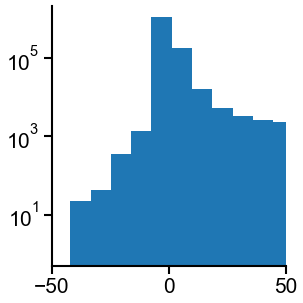

In [8]:
full_all_features = npz['all_features']

print(f"Features shape: {all_features.shape}")
hist_data = np.median(full_all_features, axis=(-2))
fig, ax = plt.subplots(1, 1, figsize=(30*MM_TO_IN, 30*MM_TO_IN))

ax.hist(hist_data.flatten(), log=True, bins=100)
ax.set_xlim(-50, 50)

In [9]:
display(pd.DataFrame(zip(range(len(dim_names)), dim_names, all_features.shape), columns=['dim', 'name', 'shape']))

,dim,name,shape
0,0,params,6
1,1,stages,4
2,2,channels,9504
3,3,bands,6
4,4,clips,10
5,5,feature_types,2


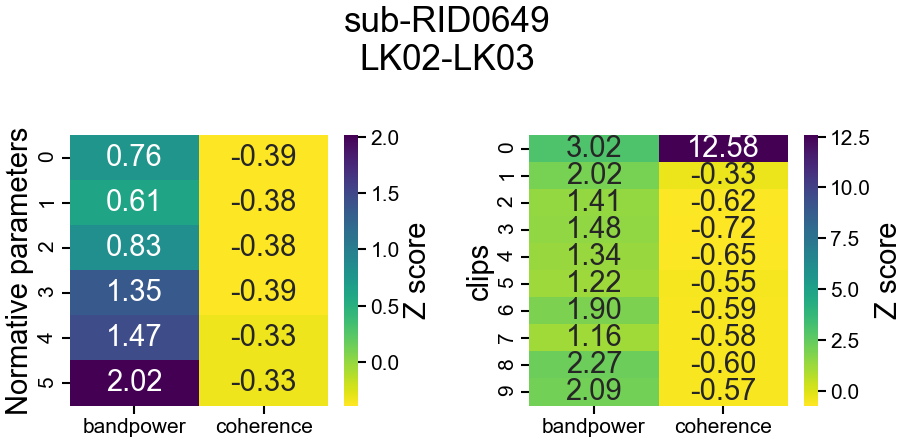

In [10]:
i_ch = 9200

fig, axes = plt.subplots(1, 2, figsize=(80*MM_TO_IN, 40*MM_TO_IN))

ax = axes[0]
sns.heatmap(
    all_features[:, -1, i_ch, 0, 1, :],
    ax=ax,
    annot=True,
    fmt='.2f',
    cmap='viridis_r',
    cbar_kws={'label': 'Z score'}
)
ax.set_xticklabels(['bandpower', 'coherence'])
ax.set_ylabel('Normative parameters')

ax = axes[1]
sns.heatmap(
    all_features[5, -1, i_ch, 0, :, :],
    ax=ax,
    annot=True,
    fmt='.2f',
    cmap='viridis_r',
    cbar_kws={'label': 'Z score'}
)
ax.set_xticklabels(['bandpower', 'coherence'])
ax.set_ylabel('clips')
fig.suptitle(f"{metadata.loc[i_ch].pt}\n{metadata.loc[i_ch]['name']}", fontdict={'size': 8})
plt.show()

## Helper functions

In [11]:
def patient_folds(n_folds, X, y, groups, fname):
    """
    Generate patient folds for cross-validation.

    Parameters:
    - n_folds (int): Number of folds to generate.
    - X (array-like): Input data.
    - y (array-like): Target labels.
    - groups (array-like): Group labels for stratified grouping.
    - fname (str): File name to save/load fold points.

    Returns:
    - fold_pts (array-like): Array of patient fold points.

    """
    if ospe(ospj(CONFIG.paths.data_dir, fname)):
        fold_pts = np.load(ospj(CONFIG.paths.data_dir, fname), allow_pickle=True)
    else:
        cv = StratifiedGroupKFold(n_splits=n_folds, shuffle=False)
        folds = cv.split(X, y, groups)
        fold_pts = []
        for fold_train, fold_test in folds:
            train_pts = metadata.loc[X[fold_train], 'pt']
            test_pts = metadata.loc[X[fold_test], 'pt']

            train_pts = sorted(np.unique(train_pts))
            test_pts = sorted(np.unique(test_pts))

            assert len(set(train_pts).intersection(set(test_pts))) == 0

            fold_pts.append(test_pts)

        fold_pts = np.array(fold_pts, dtype=object)
        np.save(ospj(CONFIG.paths.data_dir, fname), fold_pts)
    return fold_pts


In [12]:
def effect_size(x, y):
    # return (np.mean(x) - np.mean(y)) / np.sqrt((np.var(x) + np.var(y)) / 2)
    t, p = wilcoxon(x, y)
    n = len(x)
    mean_approx = n * (n + 1) / 4
    std_approx = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
    z = (t - mean_approx) / std_approx

    cohensd = np.abs(z / np.sqrt(n))
    return cohensd

## Cross-site effect sizes

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Effect sizes for 1
{'spike_threshold': 1, 'min_normative_bandpower': 10, 'min_normative_coherence': 4, 'engel_time': 12, 'engel_threshold': 1.1}
_______________________________
0.6056573806303445 bandpower
0.6151031919157259 coherence
_______________________________


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Effect sizes for 2
{'spike_threshold': 1, 'min_normative_bandpower': 10, 'min_normative_coherence': 4, 'engel_time': 12, 'engel_threshold': 1.2}
_______________________________
0.557905789962117 bandpower
0.5351956479355612 coherence
_______________________________


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Effect sizes for 3
{'spike_threshold': 1, 'min_normative_bandpower': 10, 'min_normative_coherence': 4, 'engel_time': 12, 'engel_threshold': 1.9}
_______________________________
0.5566195518296395 bandpower
0.5540872705063244 coherence
_______________________________
Effect sizes for 4
{'spike_threshold': 1, 'min_normative_bandpower': 10, 'min_normative_coherence': 4, 'engel_time': 24, 'engel_threshold': 1.1}
_______________________________
0.7031497069554775 bandpower
0.732549077613398 coherence
_______________________________


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Effect sizes for 5
{'spike_threshold': 1, 'min_normative_bandpower': 10, 'min_normative_coherence': 4, 'engel_time': 24, 'engel_threshold': 1.2}
_______________________________
0.6379741137088416 bandpower
0.5897803786825752 coherence
_______________________________


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Effect sizes for 6
{'spike_threshold': 1, 'min_normative_bandpower': 10, 'min_normative_coherence': 4, 'engel_time': 24, 'engel_threshold': 1.9}
_______________________________
0.6082700518369394 bandpower
0.5822639245959098 coherence
_______________________________
[0.6103802862730351, 0.546550718948839, 0.5553534111679822, 0.7178493922844377, 0.6138772461957084, 0.5952669882164245]
5


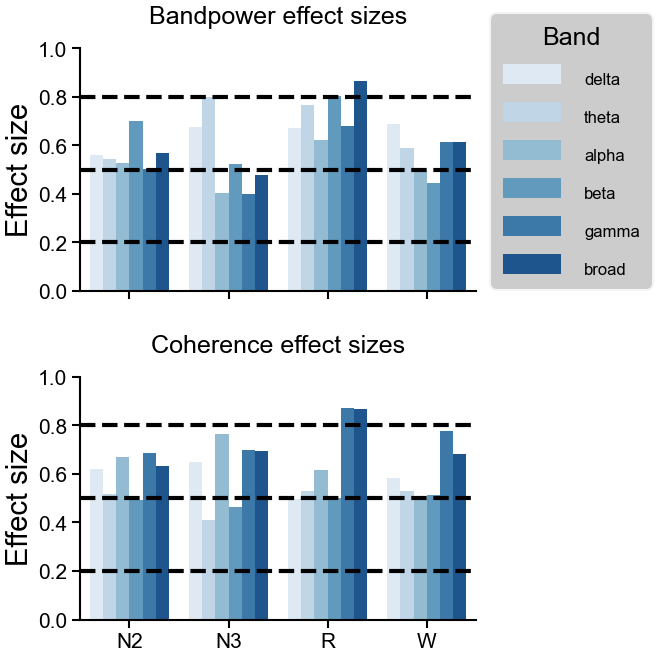

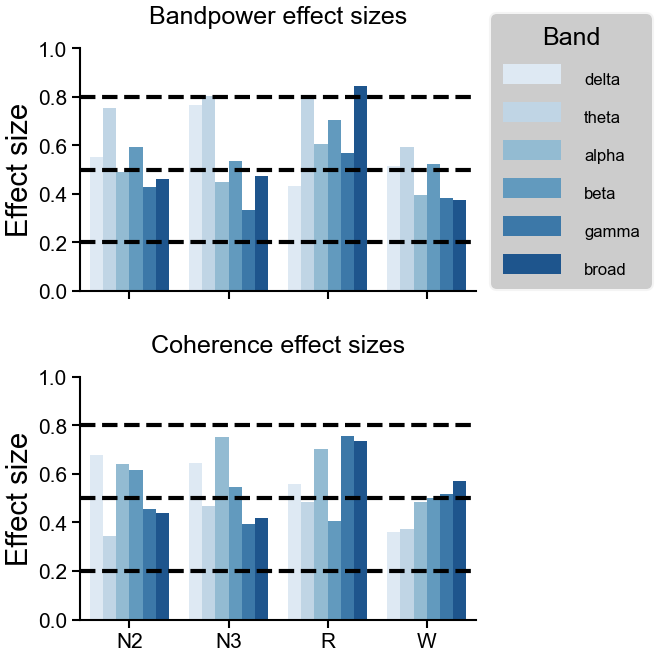

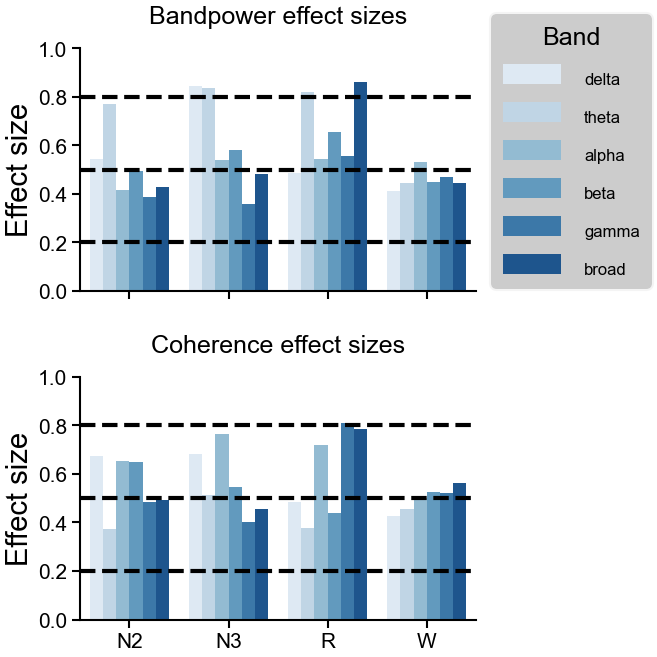

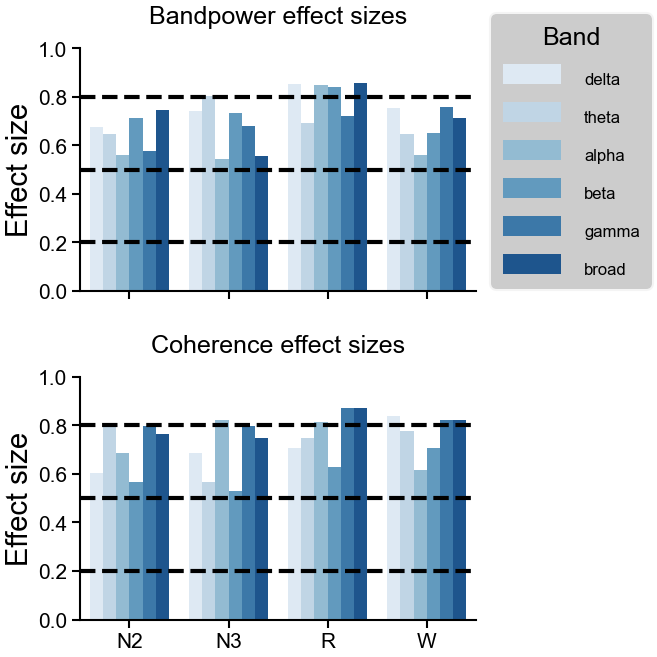

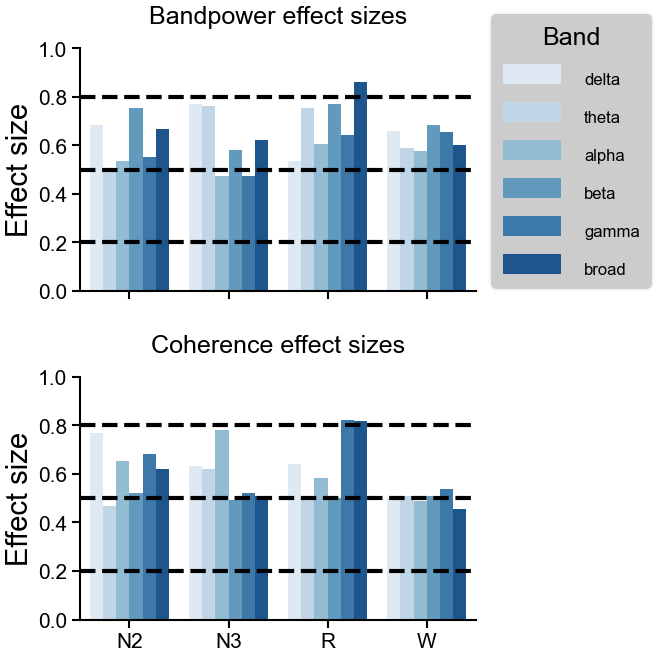

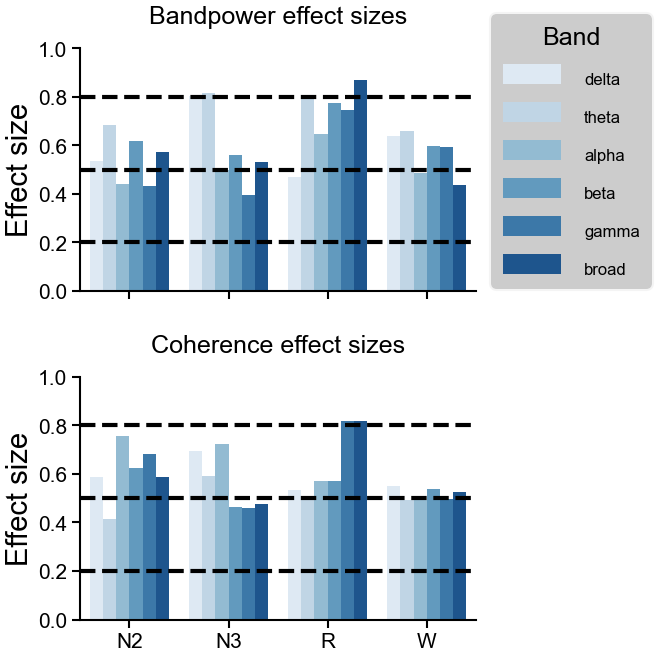

In [13]:
mean_effect_size = []

for i_params, params in enumerate(params_li):
    key = list(params.keys())[0]
    params = params[key]

    median_features = np.abs(all_features[i_params])

    # keep normative only
    normal = metadata[
        (metadata["site"] == "MNI")
        | (
            (metadata["site"] == "HUP")
            & (~metadata['pt'].isin(pts_to_ignore))
            & (metadata["ch1_spike_rate"] < params["spike_threshold"]) & (metadata["ch2_spike_rate"] < params["spike_threshold"])
            & (metadata["ch1_resected"] == False) & (metadata["ch2_resected"] == False)
            & (metadata["ch1_soz"] == False) & (metadata["ch2_soz"] == False)
            & (metadata[f"engel_{params['engel_time']}"] <= params['engel_threshold'])
        )
    ].reset_index(drop=True)

    median_features = median_features[:, normal.index]

    regs_li = normal.reg.unique()
    regs_li = sorted([r for r in regs_li if isinstance(r, str)])
    sites_li = sorted(normal.site.unique())

    reg_site_medians = np.ones((len(regs_li), len(sites_li), len(stages), len(bands), len(feature_types)))*np.nan

    for (reg, site), group in normal.groupby(['reg', 'site']):
        i_reg = regs_li.index(reg)
        i_site = sites_li.index(site)

        group_features = median_features[:, group.index]
        group_features = np.transpose(group_features, (0, 1, 3, 2, 4))
        group_features = np.reshape(group_features, (group_features.shape[0], -1, group_features.shape[-2], group_features.shape[-1]))
        
        group_vals = np.nanmedian(group_features, axis=1)
        reg_site_medians[i_reg, i_site] = group_vals

    effect_sizes = []

    for i_stage in range(len(stages)):
        for i_band in range(len(bands)):
            for i_feature in range(len(feature_types)):
                x = reg_site_medians[:, 0, i_stage, i_band, i_feature]
                y = reg_site_medians[:, 1, i_stage, i_band, i_feature]

                # effect_sizes[0, i_stage, i_band, i_feature] = effect_size(x, y)
                effect_sizes.append({
                    'stage': stages[i_stage],
                    'band': bands[i_band],
                    'feature': feature_types[i_feature],
                    'effect_size': effect_size(x, y)
                })

    effect_sizes = pd.DataFrame(effect_sizes)

    fig, axes = plt.subplots(2, 1, figsize=(60*MM_TO_IN, 60*MM_TO_IN), sharex=True)
    sns.barplot(
        data=effect_sizes[effect_sizes.feature == 'bandpower'],
        y='effect_size',
        x='stage',
        hue='band',
        ax=axes[0],
        palette='Blues',

    )
    sns.barplot(
        data=effect_sizes[effect_sizes.feature == 'coherence'],
        y='effect_size',
        x='stage',
        hue='band',
        ax=axes[1],
        palette='Blues',
    )
    # turn legend off
    axes[1].get_legend().remove()

    axes[0].set_title('Bandpower effect sizes', fontsize=6)
    axes[1].set_title('Coherence effect sizes', fontsize=6)

    axes[0].legend(title='Band')
    # make legend smaller and transparent background
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1.2), title='Band')
    leg = axes[0].get_legend()
    leg.set_title('Band')
    leg.get_frame().set_alpha(0.2)
    # make all text smaller
    for text in leg.get_texts():
        text.set_fontsize(4)
    leg.set_title('Band', prop={'size': 6})

    for ax in axes:
        ax.set_ylabel('Effect size')
        ax.set_xlabel('')
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for thresh in [0.2, 0.5, 0.8]:
            ax.axhline(thresh, color='k', linestyle='--', linewidth=1)


    print(f"Effect sizes for {key}")
    print(params)
    print("_______________________________")
    print(effect_sizes[effect_sizes.feature == 'bandpower']['effect_size'].mean(), "bandpower")
    print(effect_sizes[effect_sizes.feature == 'coherence']['effect_size'].mean(), "coherence")
    mean_effect_size.append(effect_sizes['effect_size'].mean())

    print("_______________________________")

    # fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/site_effect_sizes.pdf'), dpi=300, bbox_inches='tight')

print(mean_effect_size)

params_to_select = np.argmin(mean_effect_size)
params_to_select = len(mean_effect_size) - 1
print(params_to_select)


## Compute abnormality from z scores

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:214: RuntimeWarning: Mean of empty slice
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:214: RuntimeWarning: Mean of empty slice
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:214: RuntimeWarning: Mean of empty slice
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:214: RuntimeWarning: Mean of empty slice


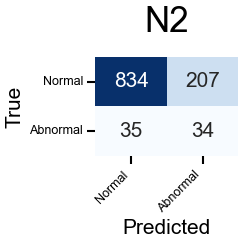

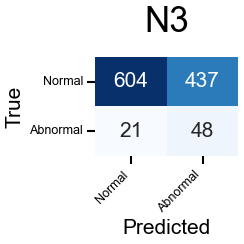

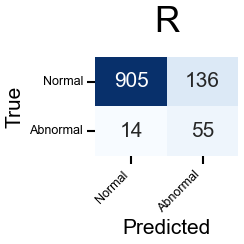

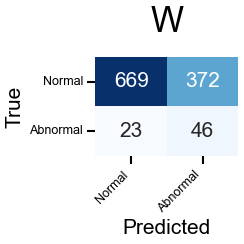

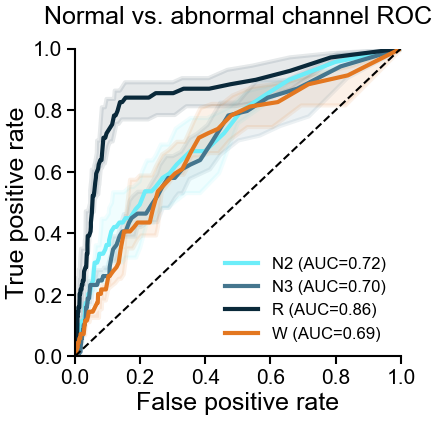

In [20]:
# set seed
np.random.seed(42)

y_true_pred = {}
all_aucs = np.zeros((len(params_li), len(stages)))
all_metrics = {}
adopted_thresholds = []

for i_params, params in enumerate(params_li):
    key = list(params.keys())[0]
    params = params[key]

    # selected = key == "2"
    selected = i_params == params_to_select

    if not selected:
        continue

    ### Define abnormal and normal, make features and labels for all
    ################################################################################################
    abnormal = metadata[
        (metadata["ch1_resected"] == True) & (metadata["ch2_resected"] == True)
        & (metadata[f"engel_{params['engel_time']}"] <= params["engel_threshold"])
        & (~metadata['pt'].isin(pts_to_ignore))
        & (metadata["engel_12"] <= params['engel_threshold'])
    ].index

    normal = metadata[
        (metadata["site"] == "MNI")
        | (
            (metadata["site"] == "HUP")
            & (~metadata['pt'].isin(pts_to_ignore))
            & (metadata["ch1_spike_rate"] < params["spike_threshold"]) & (metadata["ch2_spike_rate"] < params["spike_threshold"])
            & (metadata["ch1_resected"] == False) & (metadata["ch2_resected"] == False)
            & (metadata["ch1_soz"] == False) & (metadata["ch2_soz"] == False)
            & (metadata[f"engel_{params['engel_time']}"] <= params['engel_threshold'])
            & (metadata["engel_12"] <= params['engel_threshold'])
        )
    ].index

    assert np.all(np.isclose(all_features[i_params, :, abnormal[0], 0, 0], (all_features[i_params, :, abnormal][0, :, 0, 0]), equal_nan=True))

    model_features = np.concatenate([all_features[i_params, :, abnormal], all_features[i_params, :, normal]], axis=0) # shape: (n_channels, n_stages, n_bands, n_clips, n_features)

    # take the median feature across all clips
    model_features = np.nanmean(model_features, axis=-2) # shape: (n_channels, n_stages, n_bands, n_features)
    # model_features = model_features[:, :, :, 0, :] # shape: (n_channels, n_stages, n_bands, n_features)

    model_labels = np.concatenate([np.ones(len(abnormal)), np.zeros(len(normal))]) # shape: (n_channels)
    model_groups = np.concatenate([metadata.loc[abnormal, 'pt'], metadata.loc[normal, 'pt']]) # shape: (n_channels)
    feature_indices = np.concatenate([abnormal, normal]) # shape: (n_channels)

    ### Set and save folds
    ################################################################################################
    fold_pts = patient_folds(5, feature_indices, model_labels, model_groups, f"fold_pts_{key}.npy")

    ### remove nans
    ################################################################################################
    # remove nans if any is nan across channels, stages, bands
    nans = np.any(np.isnan(model_features), axis=(1, 2, 3)) # shape: (n_channels)

    model_features = model_features[~nans]
    feature_indices = feature_indices[~nans]
    model_labels = model_labels[~nans]
    model_groups = model_groups[~nans]

    ### Model for each stage
    ################################################################################################
    # fprs, tprs, aucs, f1s = [], [], [], []
    metrics = {s: {} for s in stages}

    abnormality_probability = np.ones((len(stages), len(metadata))) * np.nan

    for i_stage, stage in enumerate(stages):
        ### Set train and test for cross validation
        ############################################################################################
        X = model_features[:, i_stage].copy()
        if USE_BROADBAND:
            X = X.reshape(X.shape[0], -1) # shape: (n_channels, n_features (bands * features))
        else:
            X = X[:, :-1].reshape(X.shape[0], -1)
        y = model_labels.copy()
        groups = model_groups.copy()
        train_indices = feature_indices.copy()
        
        assert len(groups) == len(y) == len(X)

        if stage == 'R':
            X_rem = X.copy()
            y_rem = y.copy()

        ### Define model pipeline
        ############################################################################################
        pipe = []
        pipe.append(("smote_over", SMOTE(sampling_strategy="minority", random_state=42)))
        pipe.append(("smote_under", RandomUnderSampler(sampling_strategy="majority", random_state=42)))
        pipe.append(("clf", RandomForestClassifier(n_estimators=100, random_state=42)))

        clf = Pipeline(pipe)

        folds = np.load(ospj(CONFIG.paths.data_dir, f"fold_pts_{key}.npy"), allow_pickle=True)

        ### Fit and predict cross validated model
        ############################################################################################
        y_pred = np.ones(len(y)) * np.nan
        for fold_pt in fold_pts:
            fold_test_indices = [i for i, pt in enumerate(groups) if pt in fold_pt] # shape: (n_channels)
            fold_train_indices = [i for i, pt in enumerate(groups) if pt not in fold_pt] # shape: (n_channels)

            assert len(set(groups[fold_test_indices]).intersection(set(groups[fold_train_indices]))) == 0
            assert len(fold_test_indices) + len(fold_train_indices) == len(groups)

            if len(fold_test_indices) == 0:
                continue
            
            # Separate train and test for this fold
            X_train = X[fold_train_indices]
            y_train = y[fold_train_indices]

            X_test = X[fold_test_indices]
            y_test = y[fold_test_indices]

            clf.fit(X_train, y_train)
            y_pred[fold_test_indices] = clf.predict_proba(X_test)[:, 1]

            # get prediction threshold for confusion, using J statistic and save
            ############################################################################################
            fpr, tpr, thresholds = roc_curve(y_test, y_pred[fold_test_indices])
            adopted_threshold = thresholds[np.argmax(tpr - fpr)]
            adopted_thresholds.append({
                'key': key,
                'stage': stage,
                'test_patients': fold_pt,
                'threshold': adopted_threshold
            })

        ### Get AUC, F1, confusion matrix, and average precision
        ############################################################################################
        auc = roc_auc_score(y, y_pred)
        true_fpr, true_tpr, thresholds = roc_curve(y, y_pred)

        ### Bootstrapped ROC curve
        ############################################################################################
        n_iter = 1000
        bootstrap_aucs = []
        bootstrap_tprs = []
        bootstrap_fprs = []

        for _ in range(n_iter):
            indices = np.random.choice(len(y), len(y), replace=True)
            bootstrap_y = y[indices]
            bootstrap_y_pred = y_pred[indices]
            if len(np.unique(bootstrap_y)) < 2:
                continue
            bootstrap_auc = roc_auc_score(bootstrap_y, bootstrap_y_pred)
            fpr, tpr, _ = roc_curve(bootstrap_y, bootstrap_y_pred)
            bootstrap_fprs.append(fpr)
            bootstrap_tprs.append(tpr)
            bootstrap_aucs.append(bootstrap_auc)

        bootstrap_aucs = np.array(bootstrap_aucs)
        bootstrap_fprs = np.array(bootstrap_fprs, dtype='object')
        bootstrap_tprs = np.array(bootstrap_tprs, dtype='object')

        sort_idx = np.argsort(bootstrap_aucs)
        bootstrap_aucs = bootstrap_aucs[sort_idx]
        bootstrap_fprs = bootstrap_fprs[sort_idx]
        bootstrap_tprs = bootstrap_tprs[sort_idx]

        bootstrap_mean_auc = np.mean(bootstrap_aucs)
        bootstrap_std_auc = np.std(bootstrap_aucs)

        ### Store metrics
        ############################################################################################
        all_aucs[i_params, i_stage] = auc

        # confusion matrix
        # get prediction threshold for confusion, using J statistic
        adopted_threshold = thresholds[np.argmax(true_tpr - true_fpr)]
        conf_mat = confusion_matrix(y, y_pred > adopted_threshold)
        
        f1 = f1_score(y, y_pred > adopted_threshold)
        ap = average_precision_score(y, y_pred)

        if selected:
            y_true_pred[stage] = (y, y_pred)

        if selected:
            fig, ax = plt.subplots(1, 1, figsize=(25*MM_TO_IN, 25*MM_TO_IN))
            # make font smaller
            sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap='Blues', annot_kws={'size': 5}, cbar=False)
            ax.set_xlabel('Predicted', fontdict={'size': 5}); ax.set_ylabel('True', fontdict={'size': 5})
            ax.set_xticklabels(['Normal', 'Abnormal'], fontdict={'size': 3}, rotation=45, ha='right')
            ax.set_yticklabels(['Normal', 'Abnormal'], fontdict={'size': 3}, va='center', rotation=0)

            ax.set_title(f"{stage}")

            fig.savefig(ospj(CONFIG.paths.fig_dir, f'affinity/confusion_matrix_{stage}.pdf'), dpi=300)


        ### Store abnormality probability for 5 fold cross validation
        ############################################################################################
        abnormality_probability[i_stage, train_indices] = y_pred

        ### Train full model on remaining data
        ############################################################################################
        X_train = X
        y_train = y
        if USE_BROADBAND:
            X_test = all_features[i_params, i_stage].copy() # shape: (n_channels, n_bands, n_clips, n_features)
        else:
            X_test = all_features[i_params, i_stage, :, :-1].copy()

        X_test = np.nanmean(X_test, axis=-2)
        # X_test = X_test[:, :, 0, :]
        X_test = X_test.reshape(X_test.shape[0], -1) # shape: (n_channels, n_features (bands * features))

        test_indices = [i for i in range(len(metadata)) if i not in train_indices]
        X_test = X_test[test_indices] # shape: (n_channels, n_features)

        X_test[np.isinf(X_test)] = np.nan
        nans = np.isnan(X_test).any(axis=-1)
        X_test = X_test[~nans]
        test_indices = np.array(test_indices)[~nans]

        pipe = []
        pipe.append(("smote_over", SMOTE(sampling_strategy="minority", random_state=42)))
        pipe.append(("smote_under", RandomUnderSampler(sampling_strategy="majority", random_state=42)))
        pipe.append(("clf", RandomForestClassifier(n_estimators=100, random_state=42)))
        clf = Pipeline(pipe)

        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

        ### Store abnormality probability for full model
        ############################################################################################
        abnormality_probability[i_stage, test_indices] = y_pred

        ### Store metrics
        ############################################################################################
        metrics[stage] = {
            'auc': auc,
            'fpr': true_fpr,
            'tpr': true_tpr,
            'thresholds': thresholds,
            'f1': f1,
            'ap': ap,
            'bootstrap_aucs': bootstrap_aucs,
            'bootstrap_fprs': bootstrap_fprs,
            'bootstrap_tprs': bootstrap_tprs,
            'model': clf.named_steps['clf'],
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_pred': y_pred,
        }
        all_metrics[key] = metrics

        adopted_thresholds.append({
            'key': key,
            'stage': stage,
            'test_patients': np.unique(metadata.loc[[i for i in range(len(metadata)) if i not in train_indices], 'pt'].values),
            'threshold': adopted_threshold
        })

    ### Plot ROC curves
    ############################################################################################
    if selected:
        fig, ax = plt.subplots(1, 1, figsize=(40 * MM_TO_IN, 40 * MM_TO_IN))
        for stage in stages:
            ax.plot(
                metrics[stage]['fpr'],
                metrics[stage]['tpr'],
                label=f'{stage} (AUC={metrics[stage]["auc"]:.2f})',
                c=CONFIG.plotting.stage_colors[stage],
                lw=1
            )
            n_iter = len(metrics[stage]['bootstrap_aucs'])
            fpr_lower = metrics[stage]['bootstrap_fprs'][int(n_iter * 0.05)]
            fpr_upper = metrics[stage]['bootstrap_fprs'][int(n_iter * 0.95)]
            tpr_lower = metrics[stage]['bootstrap_tprs'][int(n_iter * 0.05)]
            tpr_upper = metrics[stage]['bootstrap_tprs'][int(n_iter * 0.95)]

            xfill = np.sort(np.concatenate([fpr_lower, fpr_upper]))
            y1fill = np.interp(xfill, fpr_lower, tpr_lower)
            y2fill = np.interp(xfill, fpr_upper, tpr_upper)

            # fill between 95 and 5 percentiles
            ax.fill_between(
                xfill, y1fill, y2fill,
                color=CONFIG.plotting.stage_colors[stage], alpha=0.1
            )

        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('False positive rate', fontsize=6)
        ax.set_ylabel('True positive rate', fontsize=6)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.legend(frameon=False, fontsize=4)

        sns.despine()
        ax.set_title("Normal vs. abnormal channel ROC", fontsize=6)
        fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/roc_curves.pdf'), dpi=300, bbox_inches='tight')

    if selected:
        np.save(ospj(CONFIG.paths.data_dir, 'abnormality_probability.npy'), abnormality_probability)
    np.save(ospj(CONFIG.paths.data_dir, f'abnormality_probability_{key}.npy'), abnormality_probability)
    # if selected:
    #     break
adopted_thresholds = pd.DataFrame(adopted_thresholds)
# adopted_thresholds.to_csv(ospj(CONFIG.paths.data_dir, 'adopted_thresholds.csv'), index=False)

<AxesSubplot:xlabel='variable', ylabel='value'>

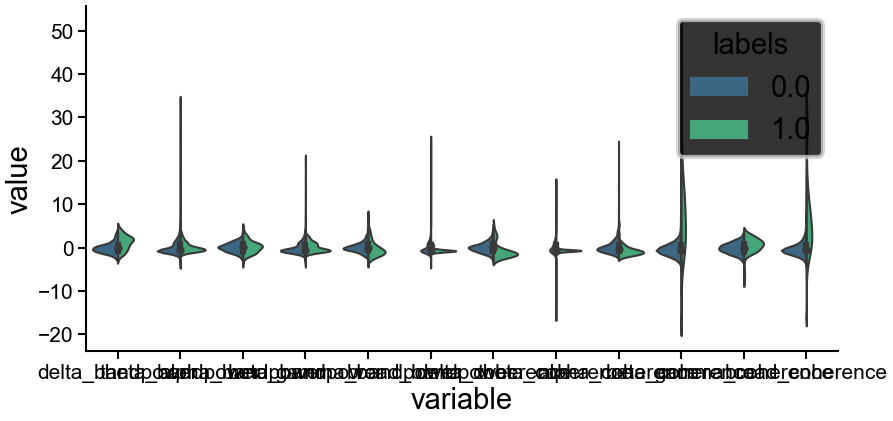

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(80 * MM_TO_IN, 40 * MM_TO_IN))

rem_data = pd.DataFrame(X_rem)

# columns are features
rem_data.columns = [f"{band}_{feature}" for feature in feature_types for band in bands]
rem_data['labels'] = y_rem

# reshape so that the features are in the columns
rem_data = rem_data.melt(id_vars='labels')

sns.violinplot(
    data=rem_data,
    y='value',
    x='variable',
    hue='labels',
    split=True,
    ax=ax,
    palette='viridis'
)

In [67]:
metadata.loc[normal].query('site == "HUP"').index

Int64Index([2058, 2069, 2077, 2085, 2093, 2101, 2109, 2115, 2116, 2122,
            ...
            8125, 8126, 8129, 8130, 8257, 8264, 8269, 8290, 8291, 8292],
           dtype='int64', length=319)

,site,ch_type,stage,abnormality_probability
0,MNI,norm MNI,N2,NaN
1,MNI,norm MNI,N2,NaN
2,MNI,norm MNI,N2,NaN
3,MNI,norm MNI,N2,NaN
4,MNI,norm MNI,N2,NaN
...,...,...,...,...
38011,HUP,None,W,0.33
38012,HUP,None,W,0.19
38013,HUP,None,W,0.14
38014,HUP,None,W,0.30


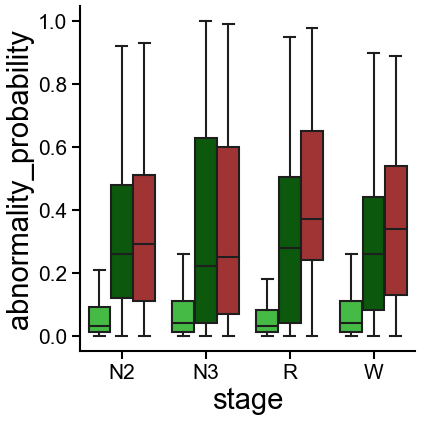

In [68]:
# differences in abnormality probability between HUP and MNI for each stage
df = pd.DataFrame(abnormality_probability.T, columns=stages)
df['site'] = metadata['site']

df['ch_type'] = None
df.loc[abnormal, 'ch_type'] = 'soz'
df.loc[metadata.loc[normal].query('site == "HUP"').index, 'ch_type'] = 'norm HUP'
df.loc[metadata.loc[normal].query('site == "MNI"').index, 'ch_type'] = 'norm MNI'

# df = df.melt(id_vars='site', var_name='stage', value_name='abnormality_probability')
df = df.melt(id_vars=['site', 'ch_type'], var_name='stage', value_name='abnormality_probability')
display(df)

fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
sns.boxplot(
    data=df,
    x='stage',
    y='abnormality_probability',
    hue='ch_type',
    ax=ax,
    palette=CONFIG.plotting.elec_type_colors,
    showfliers=False
)
ax.get_legend().remove()

In [69]:
key = list(params_li[params_to_select].keys())[0]

auc_results = f"""
The AUCs for each stage (with 95% confidence intervals after {n_iter} bootstrap iterations):
_____________________________________________________________________
N2: {all_metrics[key]['N2']['auc']:.2f} [{np.percentile(all_metrics[key]['N2']['bootstrap_aucs'], 5):.2f}, {np.percentile(all_metrics[key]['N2']['bootstrap_aucs'], 95):.2f}]
N3: {all_metrics[key]['N3']['auc']:.2f} [{np.percentile(all_metrics[key]['N3']['bootstrap_aucs'], 5):.2f}, {np.percentile(all_metrics[key]['N3']['bootstrap_aucs'], 95):.2f}]
R: {all_metrics[key]['R']['auc']:.2f} [{np.percentile(all_metrics[key]['R']['bootstrap_aucs'], 5):.2f}, {np.percentile(all_metrics[key]['R']['bootstrap_aucs'], 95):.2f}]
W: {all_metrics[key]['W']['auc']:.2f} [{np.percentile(all_metrics[key]['W']['bootstrap_aucs'], 5):.2f}, {np.percentile(all_metrics[key]['W']['bootstrap_aucs'], 95):.2f}]
"""

print(auc_results)


The AUCs for each stage (with 95% confidence intervals after 1000 bootstrap iterations):
_____________________________________________________________________
N2: 0.72 [0.67, 0.77]
N3: 0.70 [0.64, 0.75]
R: 0.86 [0.81, 0.90]
W: 0.69 [0.63, 0.74]



### DeLong's Test

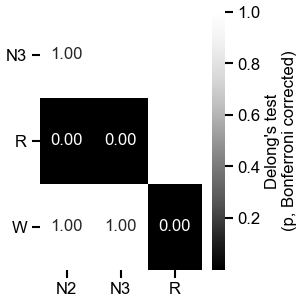

In [70]:
def delong_wrapper(s1, s2):
    """
    Calculates the p-value using the DeLong test for two sets of true labels and predicted probabilities.

    Parameters:
    s1 (int): Index of the first set of true labels and predicted probabilities in the y_true_pred dictionary.
    s2 (int): Index of the second set of true labels and predicted probabilities in the y_true_pred dictionary.

    Returns:
    float: The p-value calculated using the DeLong test.

    Raises:
    AssertionError: If the true labels of the two sets are not equal.

    """
    y_true1, y_pred1 = y_true_pred[s1]
    y_true2, y_pred2 = y_true_pred[s2]

    assert np.all(np.array(y_true1) == np.array(y_true2))

    delong_p = delong_roc_test(y_true1, y_pred1, y_pred2)
    return 10 ** delong_p

delong_ps = np.ones((len(stages), len(stages))) * np.nan
for i, j in itertools.combinations(range(len(stages)), 2):
    s1 = stages[i]
    s2 = stages[j]
    delong_ps[j, i] = delong_wrapper(s1, s2)

n_comparisons = len(list(itertools.combinations(range(len(stages)), 2)))
delong_ps = delong_ps * n_comparisons
delong_ps[delong_ps > 1] = 1

# fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
fig, ax = plt.subplots(1, 1, figsize=(30*MM_TO_IN, 30*MM_TO_IN))
sns.heatmap(
    delong_ps,
    ax=ax,
    annot=True,
    fmt='.2f',
    # cmap='viridis_r',
    cmap='Greys_r',
    cbar_kws={'label': 'Delong\'s test\n(p, Bonferroni corrected)'},
    annot_kws={'size': 4}
)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(4)
cbar_axes.tick_params(labelsize=4)

ax.set_xticklabels(stages, fontdict={'size': 4})
ax.set_yticklabels(stages, fontdict={'size': 4})
ax.set_xlim([0, 3])
ax.set_ylim([4, 1])
ax.set_yticklabels(stages, rotation=0)
ax.set_xticklabels(stages)

fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/delong_heatmap.pdf'), dpi=300, bbox_inches='tight')

## Sweep across good outcome threshold

,Good,Poor,Total
1A @ 12 mo,21,35,56
1A & B @ 12 mo,31,25,56
1A - D @ 12 mo,34,22,56
1A @ 24 mo,16,35,51
1A & B @ 24 mo,24,27,51
1A - D @ 24 mo,31,20,51


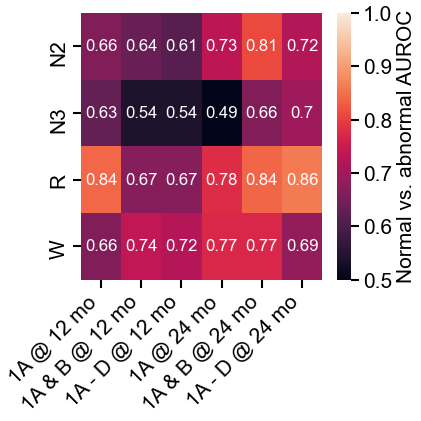

In [72]:
engel_thresh_convert = {
    1.1: "1A",
    1.2: "1A & B",
    1.9: "1A - D"
}
xticklabels = []
for i_params, params in enumerate(params_li):
    key = list(params.keys())[0]
    params = params[key]

    engel_time = params['engel_time']
    engel_threshold = params['engel_threshold']
    engel_threshold = engel_thresh_convert[engel_threshold]

    xticklabels.append(
        f"{engel_threshold} @ {engel_time} mo"
    )

n_at_each_thresh = []
indices = []
for i_params, params in enumerate(params_li):
    key = list(params.keys())[0]
    params = params[key]
    engel_time = params['engel_time']
    engel_threshold = params['engel_threshold']
    engel_threshold = engel_thresh_convert[engel_threshold]

    n_good = metadata[
            (metadata[f"engel_{params['engel_time']}"] <= params['engel_threshold']) 
            & (~pd.isna(metadata[f"engel_{params['engel_time']}"]))
            & (~metadata['pt'].isin(pts_to_ignore))
    ].pt.nunique()
    n_poor = metadata[
            (metadata[f"engel_{params['engel_time']}"] > params['engel_threshold'])
            & (~pd.isna(metadata[f"engel_{params['engel_time']}"]))
            & (~metadata['pt'].isin(pts_to_ignore))
    ].pt.nunique()
    n_at_each_thresh.append({"Good": n_good, "Poor": n_poor})
    indices.append(f"{engel_threshold} @ {engel_time} mo")
n_at_each_thresh = pd.DataFrame(n_at_each_thresh, index=indices)
n_at_each_thresh['Total'] = n_at_each_thresh.sum(axis=1)

display(n_at_each_thresh)

fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
sns.heatmap(
    all_aucs.T,
    ax=ax,
    annot=True,
    vmin=0.5,
    vmax=1,
    annot_kws={'size': 4},
    cbar_kws={'label': 'Normal vs. abnormal AUROC'}
)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(5)
ax.set_yticklabels(stages)
ax.set_xticklabels(xticklabels, ha='right', rotation=45)

# ax.set_ylabel("Stage")
# ax.set_xlabel("Good outcome threshold")

fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/aucs_engel_sweep.pdf'), dpi=300)

## Compute abnormality across multiple combinations of stages

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


(2273, 8, 6, 2)
features: (2273, 8, 6, 2), labels: (2273,), groups: (2273,), feature_indices: (2273,)
        0
0.0  2091
1.0   182
X: (1747, 24), y: (1747,), groups: (1747,)
AUC: 0.79
F1: 0.28
AP: 0.25


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (1125, 24), y: (1125,), groups: (1125,)
AUC: 0.80
F1: 0.29
AP: 0.22


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (1772, 24), y: (1772,), groups: (1772,)
AUC: 0.80
F1: 0.44
AP: 0.30


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (1124, 24), y: (1124,), groups: (1124,)
AUC: 0.87
F1: 0.35
AP: 0.27


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (1768, 24), y: (1768,), groups: (1768,)
AUC: 0.82
F1: 0.28
AP: 0.22


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (1111, 24), y: (1111,), groups: (1111,)
AUC: 0.87
F1: 0.44
AP: 0.34


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (386, 24), y: (386,), groups: (386,)
AUC: 0.54
F1: 0.36
AP: 0.44


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (380, 24), y: (380,), groups: (380,)
AUC: 0.55
F1: 0.41
AP: 0.36


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (141, 24), y: (141,), groups: (141,)
AUC: 0.31
F1: 0.00
AP: 0.27


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


X: (413, 24), y: (413,), groups: (413,)
AUC: 0.52
F1: 0.51
AP: 0.35


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


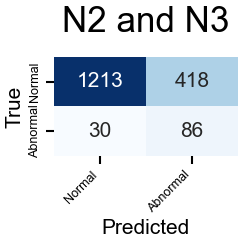

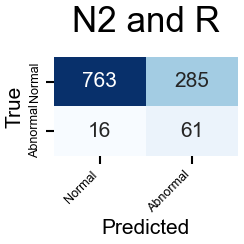

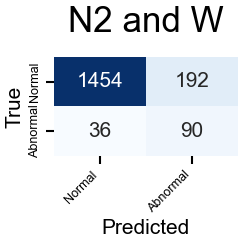

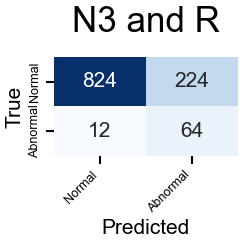

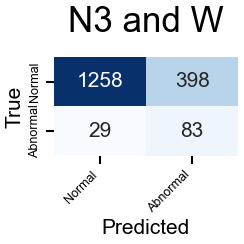

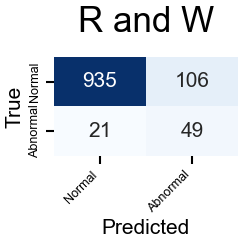

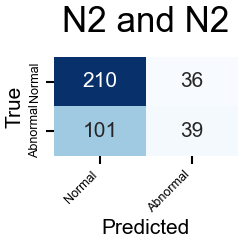

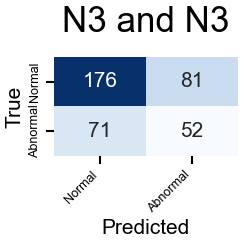

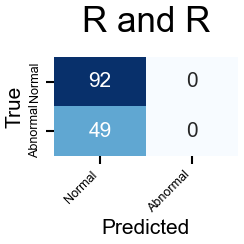

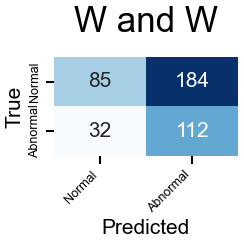

In [73]:
all_aucs = np.zeros((len(params_li), len(stages)))

USE_BROADBAND = True
# params = params_li[4]

# key = list(params.keys())[0]
# params = params[key]

# selected = key == "5"
params = params_li[params_to_select]
key = list(params.keys())[0]
params = params[key]

### Define resected and normative, make features and labels for all
################################################################################################
resected_soz_good_outcome = metadata[
    (metadata["ch1_resected"] == True) & (metadata["ch2_resected"] == True)
    & (metadata[f"engel_{params['engel_time']}"] <= params["engel_threshold"])
    & (metadata["engel_12"] <= params['engel_threshold'])
    & (~metadata['pt'].isin(pts_to_ignore))
].index

normative = metadata[
    (metadata["site"] == "MNI")
    | (
        (metadata["site"] == "HUP")
        & (~metadata['pt'].isin(pts_to_ignore))
        & (metadata["ch1_spike_rate"] < params["spike_threshold"]) & (metadata["ch2_spike_rate"] < params["spike_threshold"])
        & (metadata["ch1_resected"] == False) & (metadata["ch2_resected"] == False)
        & (metadata["ch1_soz"] == False) & (metadata["ch2_soz"] == False)
        & (metadata[f"engel_{params['engel_time']}"] <= params['engel_threshold'])
        & (metadata["engel_12"] <= params['engel_threshold'])
    )
].index

model_features = np.concatenate([all_features[i_params, :, resected_soz_good_outcome], all_features[i_params, :, normative]], axis=0)
model_labels = np.concatenate([np.ones(len(resected_soz_good_outcome)), np.zeros(len(normative))])
model_groups = np.concatenate([metadata.loc[resected_soz_good_outcome, 'pt'], metadata.loc[normative, 'pt']])
feature_indices = np.concatenate([resected_soz_good_outcome, normative])

# sort so nan are at the end of dim -2
# model_features = np.sort(model_features, axis=-2)

# take mean of every even and every odd
model_features = np.stack([np.nanmean(model_features[:, :, :, ::2], axis=-2), np.nanmean(model_features[:, :, :, 1::2], axis=-2)], axis=-2)
# print(model_features_new.shape)

# model_features = model_features[:, :, :, [0, 1], :]
# print(model_features.shape)

model_features = np.transpose(model_features, (0, 1, 3, 2, 4))
model_features = np.reshape(model_features, (model_features.shape[0], -1, model_features.shape[-2], model_features.shape[-1]))
print(model_features.shape)

combo_stages = [[f"{i}_1", f"{i}_2"] for i in stages]
combo_stages = list(itertools.chain(*combo_stages))

### Set and save folds
################################################################################################
fold_pts = patient_folds(5, feature_indices, model_labels, model_groups, f"fold_pts_{key}.npy")

### remove nans
################################################################################################
# nans = np.any(np.isnan(model_features), axis=(1, 2, 3))

# model_features = model_features[~nans]
# feature_indices = feature_indices[~nans]
# model_labels = model_labels[~nans]
# model_groups = model_groups[~nans]

print(f"features: {model_features.shape}, labels: {model_labels.shape}, groups: {model_groups.shape}, feature_indices: {feature_indices.shape}")
print(pd.Series(model_labels).value_counts().to_frame())

### Model for each stage
################################################################################################
fprs, tprs, aucs, f1s = [], [], [], []

combos = list(itertools.combinations(range(len(stages)), 2))
# add double combos
combos += [(i, i) for i in range(len(stages))]
abnormality_probability = np.ones((len(combos), len(metadata))) * np.nan

adopted_thresholds_combos = []

for i_combo, (i_stage, j_stage) in enumerate(combos):

    ### Set train and test for cross validation
    ############################################################################################
    if i_stage == j_stage:
        combo_stage_idx = [combo_stages.index(f"{stages[i_stage]}_1"), combo_stages.index(f"{stages[i_stage]}_2")]
        X = model_features[:, combo_stage_idx].copy()
    else:
        combo_stage_idx = [combo_stages.index(f"{stages[i_stage]}_1"), combo_stages.index(f"{stages[j_stage]}_1")]
        X = model_features[:, combo_stage_idx].copy()

    if USE_BROADBAND:
        X = X.reshape(X.shape[0], -1)
    else:
        raise NotImplementedError
        # X = X[:, :-1].reshape(X.shape[0], -1)
    y = model_labels.copy()
    groups = model_groups.copy()
    train_indices = feature_indices.copy()
    

    ### remove nans
    ################################################################################################
    nans = np.isnan(X).any(axis=-1)

    X = X[~nans]
    y = y[~nans]
    groups = groups[~nans]
    train_indices = train_indices[~nans]

    assert len(groups) == len(y) == len(X)

    print(f"X: {X.shape}, y: {y.shape}, groups: {groups.shape}")

    ### Define model pipeline
    ############################################################################################
    pipe = []
    pipe.append(("smote_over", SMOTE(sampling_strategy="minority", random_state=42)))
    pipe.append(("smote_under", RandomUnderSampler(sampling_strategy="majority", random_state=42)))
    pipe.append(("clf", RandomForestClassifier(n_estimators=100, random_state=42)))
    clf = Pipeline(pipe)
    # cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

    folds = np.load(ospj(CONFIG.paths.data_dir, 'fold_pts.npy'), allow_pickle=True)

    ### Fit and predict cross validated model
    ############################################################################################
    # y_pred = cross_val_predict(clf, X, y, groups=groups, cv=cv, method='predict_proba')
    # y_pred = y_pred[:, 1]

    y_pred = np.ones(len(y)) * np.nan
    for fold_pt in fold_pts:
        fold_test_indices = [i for i, pt in enumerate(groups) if pt in fold_pt]
        fold_train_indices = [i for i, pt in enumerate(groups) if pt not in fold_pt]

        assert len(set(groups[fold_test_indices]).intersection(set(groups[fold_train_indices]))) == 0
        assert len(fold_test_indices) + len(fold_train_indices) == len(groups)

        if len(fold_test_indices) == 0:
            continue

        X_train = X[fold_train_indices]
        y_train = y[fold_train_indices]

        X_test = X[fold_test_indices]
        y_test = y[fold_test_indices]

        clf.fit(X_train, y_train)
        y_pred[fold_test_indices] = clf.predict_proba(X_test)[:, 1]

        # get prediction threshold for confusion, using J statistic and save
        ############################################################################################
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[fold_test_indices])
        adopted_threshold = thresholds[np.argmax(tpr - fpr)]
        adopted_thresholds_combos.append({
            'combo': (stages[i_stage], stages[j_stage]),
            'test_patients': fold_pt,
            'threshold': adopted_threshold
        })


    ### Get AUC, F1, confusion matrix, and average precision
    ############################################################################################
    auc = roc_auc_score(y, y_pred)
    aucs.append(auc)
    print(f'AUC: {auc:.2f}')

    y_true_pred[(stages[i_stage], stages[j_stage])] = (y, y_pred)

    all_aucs[i_params, i_stage] = auc

    fpr, tpr, thresholds = roc_curve(y, y_pred)
    fprs.append(fpr)
    tprs.append(tpr)

    # confusion matrix
    # get prediction threshold for confusion, using J statistic
    adopted_threshold = thresholds[np.argmax(tpr - fpr)]
    conf_mat = confusion_matrix(y, y_pred > adopted_threshold)

    if selected:
        fig, ax = plt.subplots(1, 1, figsize=(25*MM_TO_IN, 25*MM_TO_IN))
        # make font smaller
        sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap='Blues', annot_kws={'size': 5}, cbar=False)
        ax.set_xlabel('Predicted', fontdict={'size': 5}); ax.set_ylabel('True', fontdict={'size': 5})
        ax.set_xticklabels(['Normal', 'Abnormal'], fontdict={'size': 3}, rotation=45, ha='right')
        ax.set_yticklabels(['Normal', 'Abnormal'], fontdict={'size': 3}, va='center')
        ax.set_title(f"{stages[i_stage]} and {stages[j_stage]}")


    # get threshold for f1
    f1s.append(f1_score(y, y_pred > adopted_threshold))
    print(f'F1: {f1s[-1]:.2f}')

    ap = average_precision_score(y, y_pred)
    print(f'AP: {ap:.2f}')

    ### Store abnormality probability
    ############################################################################################
    abnormality_probability[i_combo, train_indices] = y_pred

    ### Train full model on remaining data
    ############################################################################################
    X_train = X
    y_train = y
    if USE_BROADBAND:
        X_test = all_features[i_params, [i_stage, j_stage]].copy()
    else:
        X_test = all_features[i_params, [i_stage, j_stage], :, :-1].copy()
    X_test = np.nanmedian(X_test, axis=-2)
    X_test = X_test.transpose((1, 0, 2, 3))
    X_test = X_test.reshape(X_test.shape[0], -1)

    X_test = X_test[[i for i in range(len(metadata)) if i not in train_indices]]
    test_indices = [i for i in range(len(metadata)) if i not in train_indices]


    X_test[np.isinf(X_test)] = np.nan
    nans = np.isnan(X_test).any(axis=-1)
    X_test = X_test[~nans]
    test_indices = np.array(test_indices)[~nans]

    pipe = []
    pipe.append(("smote_over", SMOTE(sampling_strategy="minority", random_state=42)))
    pipe.append(("smote_under", RandomUnderSampler(sampling_strategy="majority", random_state=42)))
    pipe.append(("clf", RandomForestClassifier(n_estimators=100, random_state=42)))
    clf = Pipeline(pipe)

    clf.fit(X, y)
    y_pred = clf.predict_proba(X_test)[:, 1]
    abnormality_probability[i_combo, test_indices] = y_pred

    adopted_thresholds_combos.append({
        'combo': (stages[i_stage], stages[j_stage]),
        'test_patients': np.unique(metadata.loc[[i for i in range(len(metadata)) if i not in train_indices], 'pt'].values),
        'threshold': adopted_threshold
    })

np.save(ospj(CONFIG.paths.data_dir, 'abnormality_probability_combo.npy'), abnormality_probability)
adopted_thresholds_combos = pd.DataFrame(adopted_thresholds_combos)
adopted_thresholds_combos.to_pickle(ospj(CONFIG.paths.data_dir, 'adopted_thresholds_combo.pkl'))

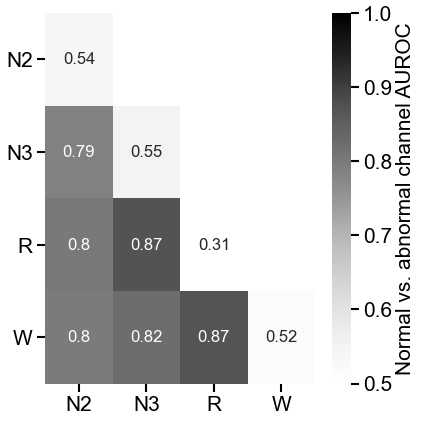

In [74]:
aucs_square = np.ones((len(stages), len(stages))) * np.nan

for i_combo, (i_stage, j_stage) in enumerate(combos):
    aucs_square[j_stage, i_stage] = aucs[i_combo]

fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
sns.heatmap(
    aucs_square,
    ax=ax,
    annot=True,
    vmin=0.5,
    vmax=1,
    annot_kws={'size': 4},
    cbar_kws={'label': 'Normal vs. abnormal channel AUROC'},
    cmap="Greys"
)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(5)


ax.set_yticklabels(stages, rotation=0)
ax.set_xticklabels(stages)

fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/combo_aucs.pdf'), dpi=300, bbox_inches='tight')

## Compute feature importance

In [75]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(clf, X, y, stage, n_repeats=30):
    """
    Plot permutation importance for a classifier.

    Parameters:
    - clf (sklearn classifier): Classifier to calculate permutation importance for.
    - X (array-like): Input data.
    - y (array-like): Target labels.
    - n_repeats (int): Number of permutations to calculate.

    Returns:
    - df (pd.DataFrame): Dataframe of permutation importances.
    """
    result = permutation_importance(clf, X.values, y, n_repeats=n_repeats, random_state=42)
    sorted_idx = result.importances_mean.argsort()

    df = pd.DataFrame(result.importances[sorted_idx].T, columns=np.array(X.columns)[sorted_idx])
    # flatten df
    df = df.melt(var_name='feature', value_name='importance')
    df['stage'] = stage
    return df

key = params_li[params_to_select]
key = list(key.keys())[0]

all_dfs = []
for i_stage, stage in enumerate(stages):
    clf = all_metrics[key][stage]['model']
    X = all_metrics[key][stage]['X_train']
    y = all_metrics[key][stage]['y_train']

    X = pd.DataFrame(X, columns=[f'{band} {feature_type}'  for band in bands for feature_type in feature_types])
    df = plot_permutation_importance(clf, X, y, stage)
    all_dfs.append(df)

all_dfs = pd.concat(all_dfs)

# sort by median importance for each feature
median_importance = all_dfs.groupby('feature').importance.median().sort_values().index
all_dfs = all_dfs.set_index('feature').loc[median_importance].reset_index()

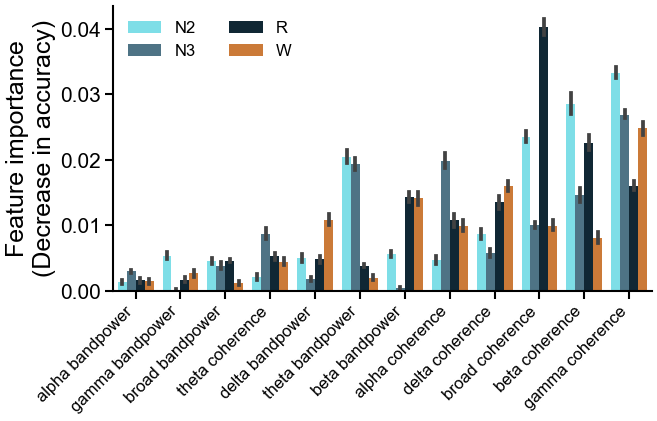

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(60*MM_TO_IN, 40*MM_TO_IN))
sns.barplot(
    data=all_dfs,
    y='importance',
    x='feature',
    hue='stage',
    orient='v',
    ax=ax,
    palette=CONFIG.plotting.stage_colors,
)
# make yticklabels smaller
ax.set_xticklabels(ax.get_xticklabels(), size=4, rotation=45, ha='right')
ax.set_xlabel(""); ax.set_ylabel("Feature importance\n(Decrease in accuracy)", fontsize=6)
ax.legend(loc='upper left', fontsize=4, frameon=False, ncol=2)

fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/permutation_importance.pdf'), dpi=300, bbox_inches='tight')

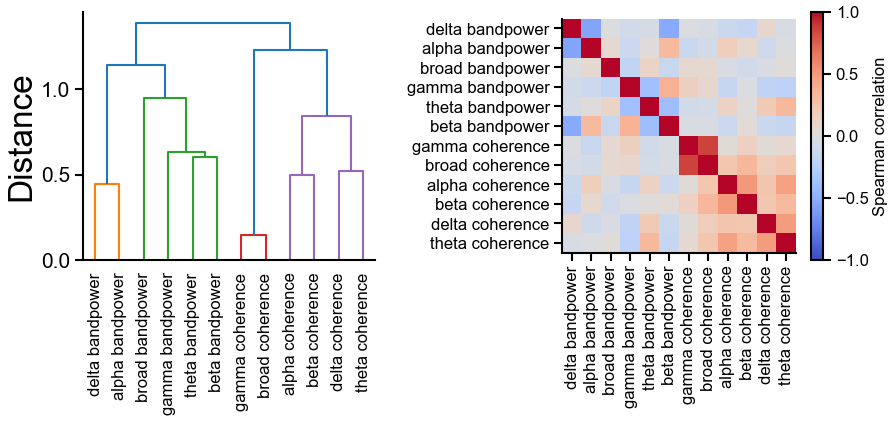

In [77]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

feature_names = [f'{band} {feature_type}'  for band in bands for feature_type in feature_types]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(80*MM_TO_IN, 40*MM_TO_IN))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=feature_names, ax=ax1, leaf_font_size=4, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax1.set_ylabel('Distance', fontsize=8)

im = ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']], cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation=90, fontsize=4)
ax2.set_yticklabels(dendro['ivl'], fontsize=4)

# add colorbar
cbar = ax2.figure.colorbar(im, ax=ax2)
cbar.ax.tick_params(labelsize=4)
# set cbar label
cbar.set_label('Spearman correlation', fontsize=4)

# plt.tight_layout()
fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/feature_correlation.pdf'), dpi=300, bbox_inches='tight')

## Z score stability

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


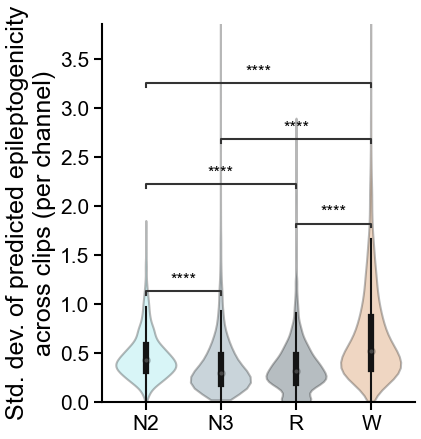

In [78]:
variances = all_features[4]
variances = np.nanstd(variances, axis=-2)

# print(variances.shape) # (n_stages, n_channels, n_bands, n_features)

i_band = 0
i_feature = 0

fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))

data = pd.DataFrame(variances[:, :, i_band, i_feature], index=stages).T

data.dropna(axis=0, inplace=True)
# drop rows with all zeros
data = data.loc[(data != 0).any(axis=1)]

# sns.boxplot(
#     data=data,
#     ax=ax,
#     showfliers=False,
#     palette=CONFIG.plotting.stage_colors,
#     # fliersize=0.2
# )

sns.violinplot(
    data=data,
    ax=ax,
    showfliers=False,
    palette=CONFIG.plotting.stage_colors,
    scale='width',
    cut=0,
    # set alpha to 0.5 to show the underlying boxplot
    inner='box',
    linewidth=0.5,
)
plt.setp(ax.collections, alpha=.3)

ax.set_ylim([0, 2])
ax.set_ylabel('Std. dev. of predicted epileptogenicity\nacross clips (per channel)', fontsize=6)

fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/variance_across_stages.pdf'), dpi=300, bbox_inches='tight')

# paired comparisons
pairs = [
    ('N2', 'N3'),
    ('N2', 'R'),
    ('N2', 'W'),
    ('N3', 'R'),
    ('N3', 'W'),
    ('R', 'W')
]
annot = Annotator(
    plot='boxplot',
    pairs=pairs,
    verbose=False,
    data = data,
    hide_non_significant=True,
    ax=ax
)
annot.configure(
    test='Wilcoxon',
    loc='inside',
    comparisons_correction="Holm-Bonferroni",
    verbose=False,
    line_width=0.5,
)
annot.apply_test()
ax, test_results = annot.annotate()

for text in ax.texts:
    text.set_fontsize(4)

# save
# fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/variance_across_stages_w_stats.pdf'), dpi=300, bbox_inches='tight')



### Figure out how many are missclassified for each channel

In [79]:
params = params_li[4]
key, params = list(params.items())[0]
i_params = 4

### Define abnormal and normal, make features and labels for all
################################################################################################
abnormal = metadata[
    (metadata["ch1_resected"] == True) & (metadata["ch2_resected"] == True)
    & (metadata[f"engel_{params['engel_time']}"] <= params["engel_threshold"])
    & (~metadata['pt'].isin(pts_to_ignore))
].index

normal = metadata[
    (metadata["site"] == "MNI")
    | (
        (metadata["site"] == "HUP")
        & (~metadata['pt'].isin(pts_to_ignore))
        & (metadata["ch1_spike_rate"] < params["spike_threshold"]) & (metadata["ch2_spike_rate"] < params["spike_threshold"])
        & (metadata["ch1_resected"] == False) & (metadata["ch2_resected"] == False)
        & (metadata["ch1_soz"] == False) & (metadata["ch2_soz"] == False)
        & (metadata[f"engel_{params['engel_time']}"] <= params['engel_threshold'])
    )
].index


model_features = np.concatenate([all_features[i_params, :, abnormal], all_features[i_params, :, normal]], axis=0)

# # median across all clips
# with warnings.catch_warnings():
#     model_features = np.nanmedian(model_features, axis=-2)
# model_features = model_features[:, :, :, 0, :]

model_labels = np.concatenate([np.ones(len(abnormal)), np.zeros(len(normal))])
model_groups = np.concatenate([metadata.loc[abnormal, 'pt'], metadata.loc[normal, 'pt']])
feature_indices = np.concatenate([abnormal, normal])

print(f"features: {model_features.shape}, labels: {model_labels.shape}, groups: {model_groups.shape}, feature_indices: {feature_indices.shape}")


### Set and save folds
################################################################################################
fold_pts = patient_folds(5, feature_indices, model_labels, model_groups, f"fold_pts_{key}.npy")

### remove nans
################################################################################################
nans = np.any(np.isnan(model_features), axis=(1, 2, 4))
nans = np.all(nans, axis=1)

model_features = model_features[~nans]
feature_indices = feature_indices[~nans]
model_labels = model_labels[~nans]
model_groups = model_groups[~nans]

model_features = np.transpose(model_features, (0, 3, 1, 2, 4))
print(f"features: {model_features.shape}, labels: {model_labels.shape}, groups: {model_groups.shape}, feature_indices: {feature_indices.shape}")


### Model for each stage
################################################################################################

misclassifications = {"idx": [], "y_true": [], "y_pred": [], "y_pred_proba": [], "stage": [], "n_clips": []}

for i_stage, stage in enumerate(stages):
    ### Set train and test for cross validation
    ############################################################################################
    X = model_features[:, :, i_stage].copy()
    if USE_BROADBAND:
        X = X.reshape(X.shape[0], X.shape[1], -1)
    else:
        X = X[:, :-1].reshape(X.shape[0], X.shape[1], -1)
    y = model_labels.copy()
    groups = model_groups.copy()
    train_indices = feature_indices.copy()  

    # X = np.nanmedian(X, axis=1)
    
    assert len(groups) == len(y) == len(X)

    ### Define model pipeline
    ############################################################################################
    pipe = []
    pipe.append(("smote_over", SMOTE(sampling_strategy="minority", random_state=42)))
    pipe.append(("smote_under", RandomUnderSampler(sampling_strategy="majority", random_state=42)))
    pipe.append(("clf", RandomForestClassifier(n_estimators=100, random_state=42)))

    clf = Pipeline(pipe)

    folds = np.load(ospj(CONFIG.paths.data_dir, f"fold_pts_{key}.npy"), allow_pickle=True)

    ### Fit and predict cross validated model
    ############################################################################################
    y_pred = np.ones(len(y)) * np.nan
    for fold_pt in fold_pts:
        fold_test_indices = [i for i, pt in enumerate(groups) if pt in fold_pt]
        fold_train_indices = [i for i, pt in enumerate(groups) if pt not in fold_pt]

        assert len(set(groups[fold_test_indices]).intersection(set(groups[fold_train_indices]))) == 0
        assert len(fold_test_indices) + len(fold_train_indices) == len(groups)

        if len(fold_test_indices) == 0:
            continue

        X_train = X[fold_train_indices]
        y_train = y[fold_train_indices]
        # y_train is (n,), make it (n, X_train.shape[1])
        X_train = np.nanmean(X_train, axis=1)

        # y_train = np.expand_dims(y_train, axis=-1)
        # y_train = np.repeat(y_train, X_train.shape[1], axis=-1)

        X_train = X_train.reshape(-1, X_train.shape[-1])
        y_train = y_train.reshape(-1)

        clf.fit(X_train, y_train)

        # nans = np.isnan(X_train).any(axis=-1)
        # X_train = X_train[~nans]
        # y_train = y_train[~nans]


        # test_indices = np.expand_dims(test_indices, axis=-1)
        # test_indices = np.repeat(test_indices, X_test.shape[1], axis=-1)

        print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}, test_indices: {test_indices.shape}")

        for i_clips in range(1, 11):
            X_test = X[fold_test_indices]
            y_test = y[fold_test_indices]

            test_indices = np.array(fold_test_indices)

            X_test = np.nanmean(X_test[:, :i_clips], axis=1)
            X_test = X_test.reshape(-1, X_test.shape[-1])

            nans = np.isnan(X_test).any(axis=-1)
            test_indices = test_indices[~nans]
            X_test = X_test[~nans]
            y_test = y_test[~nans]

            preds = clf.predict(X_test)
            preds_proba = clf.predict_proba(X_test)[:, 1]

            misclassifications["idx"].extend(test_indices)
            misclassifications["y_true"].extend(y_test)
            misclassifications["y_pred"].extend(preds)
            misclassifications["y_pred_proba"].extend(preds_proba)
            misclassifications["stage"].extend([stage] * len(test_indices))
            misclassifications["n_clips"].extend([i_clips] * len(test_indices))

        # print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}, test_indices: {test_indices.shape}")
        # raise SystemExit
        # test_indices = test_indices.reshape(-1)

        # y_test = np.expand_dims(y_test, axis=-1)
        # y_test = np.repeat(y_test, X_test.shape[1], axis=-1)
        # y_test = y_test.reshape(-1)

        # X_test = X_test.reshape(-1, X_test.shape[-1])

        # nans = np.isnan(X_test).any(axis=-1)
        # test_indices = test_indices[~nans]
        # X_test = X_test[~nans]
        # y_test = y_test[~nans]

        # # y_pred[fold_test_indices] = clf.predict_proba(X_test)[:, 1]
        # # y_pred[fold_test_indices] = clf.predict(X_test)

        # preds = clf.predict(X_test)
        # preds_proba = clf.predict_proba(X_test)[:, 1]
        
        # misclassifications["idx"].extend(test_indices)
        # misclassifications["y_true"].extend(y_test)
        # misclassifications["y_pred"].extend(preds)
        # misclassifications["y_pred_proba"].extend(preds_proba)
        # misclassifications["stage"].extend([stage] * len(test_indices))
        
        # get prediction threshold for confusion, using J statistic and save
        ############################################################################################

misclassifications = pd.DataFrame(misclassifications)
display(misclassifications)

features: (2144, 4, 6, 10, 2), labels: (2144,), groups: (2144,), feature_indices: (2144,)
features: (1018, 10, 4, 6, 2), labels: (1018,), groups: (1018,), feature_indices: (1018,)
X_train: (833, 12), y_train: (833,), X_test: (7493, 24), y_test: (113,), test_indices: (7493,)
X_train: (829, 12), y_train: (829,), X_test: (185, 12), y_test: (185,), test_indices: (185,)
X_train: (801, 12), y_train: (801,), X_test: (189, 12), y_test: (189,), test_indices: (189,)
X_train: (816, 12), y_train: (816,), X_test: (217, 12), y_test: (217,), test_indices: (217,)
X_train: (793, 12), y_train: (793,), X_test: (202, 12), y_test: (202,), test_indices: (202,)
X_train: (833, 12), y_train: (833,), X_test: (225, 12), y_test: (225,), test_indices: (225,)
X_train: (829, 12), y_train: (829,), X_test: (185, 12), y_test: (185,), test_indices: (185,)
X_train: (801, 12), y_train: (801,), X_test: (189, 12), y_test: (189,), test_indices: (189,)
X_train: (816, 12), y_train: (816,), X_test: (217, 12), y_test: (217,), te

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: Mean of empty slice
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: Mean of empty slice


X_train: (816, 12), y_train: (816,), X_test: (217, 12), y_test: (217,), test_indices: (217,)


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: Mean of empty slice


X_train: (793, 12), y_train: (793,), X_test: (202, 12), y_test: (202,), test_indices: (202,)
X_train: (833, 12), y_train: (833,), X_test: (225, 12), y_test: (225,), test_indices: (225,)
X_train: (829, 12), y_train: (829,), X_test: (185, 12), y_test: (185,), test_indices: (185,)
X_train: (801, 12), y_train: (801,), X_test: (189, 12), y_test: (189,), test_indices: (189,)


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: Mean of empty slice


X_train: (816, 12), y_train: (816,), X_test: (217, 12), y_test: (217,), test_indices: (217,)
X_train: (793, 12), y_train: (793,), X_test: (202, 12), y_test: (202,), test_indices: (202,)


,idx,y_true,y_pred,y_pred_proba,stage,n_clips
0,61,0.0,0.0,0.13,N2,1
1,62,0.0,0.0,0.08,N2,1
2,63,0.0,0.0,0.42,N2,1
3,64,0.0,0.0,0.04,N2,1
4,65,0.0,0.0,0.11,N2,1
...,...,...,...,...,...,...
40708,1013,0.0,0.0,0.19,W,10
40709,1014,0.0,1.0,0.59,W,10
40710,1015,0.0,0.0,0.27,W,10
40711,1016,0.0,0.0,0.44,W,10


In [80]:
misclassifications['diff_prediction'] = None

for (idx, stage), group in misclassifications.groupby(['idx', 'stage']):
    final_pred = group.query('n_clips == 10')['y_pred_proba'].values[0]

    misclassifications.at[group.index, 'diff_prediction'] = np.abs(final_pred - group['y_pred_proba'])

display(misclassifications)

,idx,y_true,y_pred,y_pred_proba,stage,n_clips,diff_prediction
0,61,0.0,0.0,0.13,N2,1,0.0
1,62,0.0,0.0,0.08,N2,1,0.0
2,63,0.0,0.0,0.42,N2,1,0.0
3,64,0.0,0.0,0.04,N2,1,0.0
4,65,0.0,0.0,0.11,N2,1,0.0
...,...,...,...,...,...,...,...
40708,1013,0.0,0.0,0.19,W,10,0.0
40709,1014,0.0,1.0,0.59,W,10,0.0
40710,1015,0.0,0.0,0.27,W,10,0.0
40711,1016,0.0,0.0,0.44,W,10,0.0


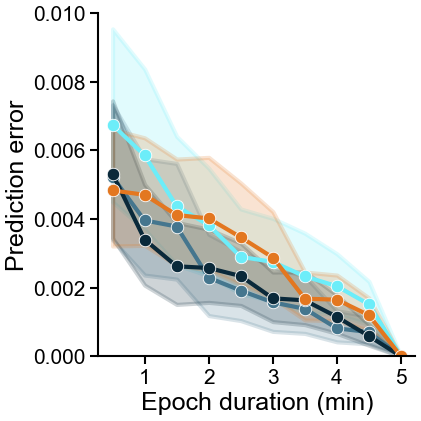

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
sns.lineplot(
    data=misclassifications,
    x='n_clips',
    y='diff_prediction',
    hue='stage',
    ax=ax,
    palette=CONFIG.plotting.stage_colors,
    err_style='band',
    err_kws={'alpha': 0.2},
    lw=1,
    marker='o',
    markersize=3,
    markeredgewidth=0.2,
)
ax.legend().remove()
ax.set_xticks(np.arange(2, 11, 2, dtype=int))
ax.set_xticklabels(np.arange(1, 6, dtype=int))
ax.set_xlabel('Epoch duration (min)', fontsize=6)
ax.set_ylabel("Prediction error", fontsize=6)
ax.set_ylim([0, 0.01])

# save
fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/prediction_error_vs_n_clips.pdf'), dpi=300, bbox_inches='tight')

In [82]:
# set seed
np.random.seed(0)

vars = misclassifications.groupby('idx').apply(lambda x: np.var(x['y_pred_proba'].values))

vars_li = []    
# variance over number of clips
for i_clips in range(2, 11):

    var = misclassifications.groupby(['idx', 'stage']).apply(lambda x: np.std(x['y_pred_proba'].values[np.random.choice(len(x), i_clips)] if len(x) >= i_clips else np.nan))
    # var = misclassifications.groupby(['idx', 'stage']).apply(lambda x: np.var(x['y_pred_proba'].values[np.random.choice(len(x), i_clips)] if len(x) >= i_clips else np.nan))
    # var = misclassifications.groupby('idx').filter(lambda x: len(x) >= i_clips).groupby(['idx', 'stage']).apply(lambda x: np.std(x['y_pred_proba'].values[np.random.choice(len(x), i_clips)]))
    var = pd.DataFrame(var).reset_index()
    var['n_clips'] = i_clips
    vars_li.append(var)

# turn list of series into dataframe where new columns are the number of clips
vars_df = pd.concat(vars_li, axis=0)
vars_df.rename(columns={0: 'variance'}, inplace=True)
vars_df.dropna(subset=['variance'], inplace=True)
vars_df.sort_values(by=['idx', 'stage', 'n_clips'], inplace=True)    

In [83]:
vars_df.dropna(subset=['variance']).n_clips.value_counts()

2     4072
3     4072
4     4072
5     4072
6     4072
7     4072
8     4072
9     4071
10    4066
Name: n_clips, dtype: int64

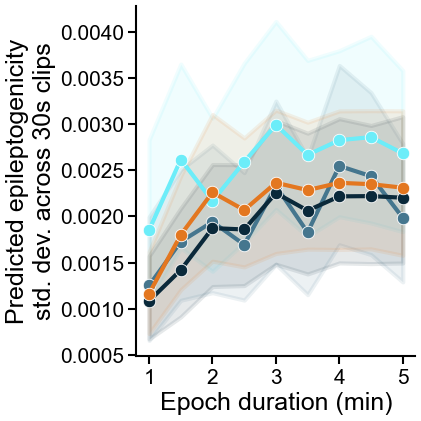

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
sns.lineplot(
    data=vars_df,
    x='n_clips',
    y='variance',
    hue='stage',
    ax=ax,
    palette=CONFIG.plotting.stage_colors,
    # make error band lighter
    err_style='band',
    err_kws={'alpha': 0.1},
    lw=1,
    marker='o',
    markersize=3,
    markeredgewidth=0.2,
)

ax.legend().remove()
ax.set_xticks(np.arange(2, 11, 2, dtype=int))
ax.set_xticklabels(np.arange(1, 6, dtype=int))
ax.set_xlabel('Epoch duration (min)', fontsize=6)
ax.set_ylabel("Predicted epileptogenicity\nstd. dev. across 30s clips", fontsize=6)

fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/variance_across_clips.pdf'), dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='stage', ylabel='n_misclassified'>

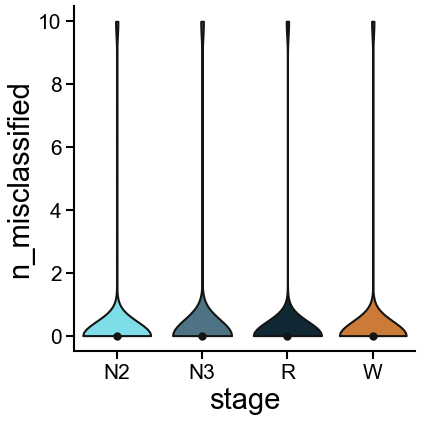

In [85]:
misclassifications['is_misclassified'] = misclassifications['y_true'] != misclassifications['y_pred']

pct_misclass = misclassifications.groupby(['stage', 'idx']).is_misclassified.mean().reset_index()

n_misclass = misclassifications.groupby(['stage', 'idx']).is_misclassified.sum().reset_index()

n_clips = misclassifications.groupby(['stage', 'idx']).is_misclassified.size().reset_index()

proba_variance = misclassifications.groupby(['stage', 'idx']).y_pred_proba.var().reset_index()

# combine
pct_misclass = pct_misclass.merge(n_misclass, on=['stage', 'idx'], suffixes=('_pct', '_n'))
pct_misclass = pct_misclass.merge(n_clips, on=['stage', 'idx'])
pct_misclass = pct_misclass.merge(proba_variance, on=['stage', 'idx'])
pct_misclass.rename(columns={'is_misclassified_pct': 'is_misclassified', 'is_misclassified_n': 'n_misclassified', 'is_misclassified': 'n_clips', 'y_pred_proba': 'proba_variance'}, inplace=True)
pct_misclass = pct_misclass[pct_misclass.n_clips > 1]

fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
sns.violinplot(
    data=pct_misclass[pct_misclass.n_clips > 1],
    x='stage',
    y='n_misclassified',
    palette=CONFIG.plotting.stage_colors,
    # showfliers=False,
    cut=0,
)


Text(0, 0.5, 'Variance in predicted probability')

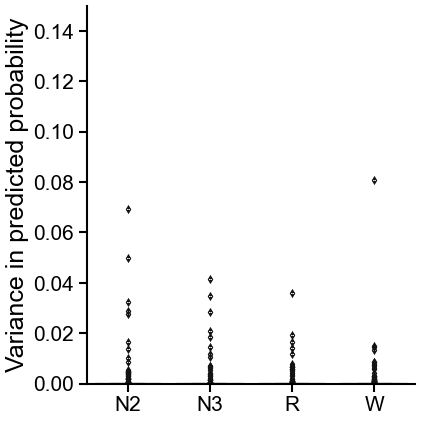

In [86]:
# violin plot of predicted probabilities
fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
sns.boxplot(
    data=pct_misclass[pct_misclass.n_clips > 1],
    x='stage',
    y='proba_variance',
    palette=CONFIG.plotting.stage_colors,
    # showfliers=False,
    # cut=0,
    fliersize=0.2
)
ax.set_ylim([0, 0.15])
ax.set_xlabel("")
ax.set_ylabel("Variance in predicted probability", fontsize=6)

# # paired comparisons
# pairs = [
#     ('N2', 'N3'),
#     ('N2', 'R'),
#     ('N2', 'W'),
#     ('N3', 'R'),
#     ('N3', 'W'),
#     ('R', 'W')
# ]

# annot = Annotator(
#     plot='boxplot',
#     pairs=pairs,
#     verbose=False,
#     data = pct_misclass[pct_misclass.n_clips > 1],
#     hide_non_significant=True,
#     ax=ax
# )


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


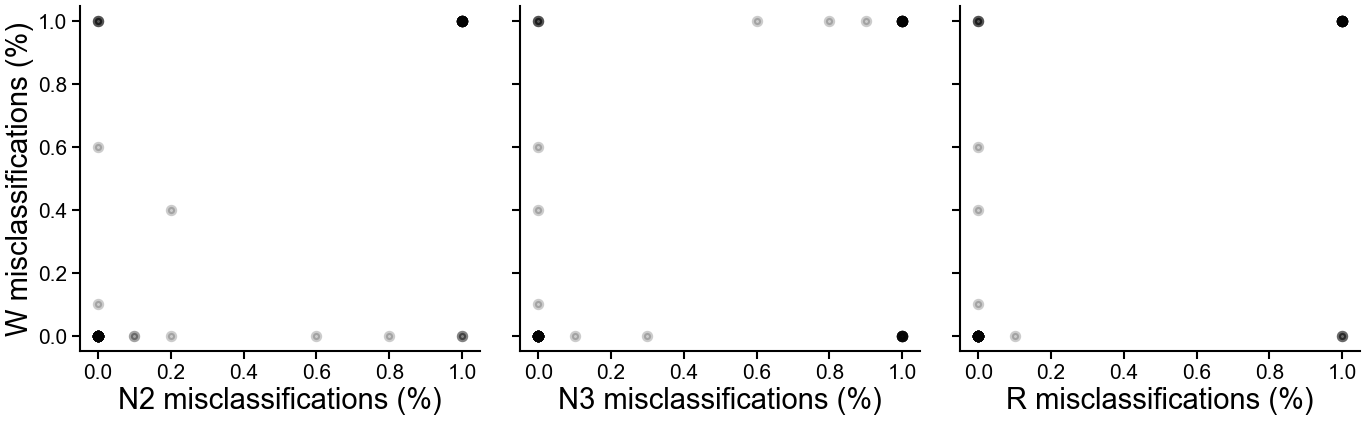

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


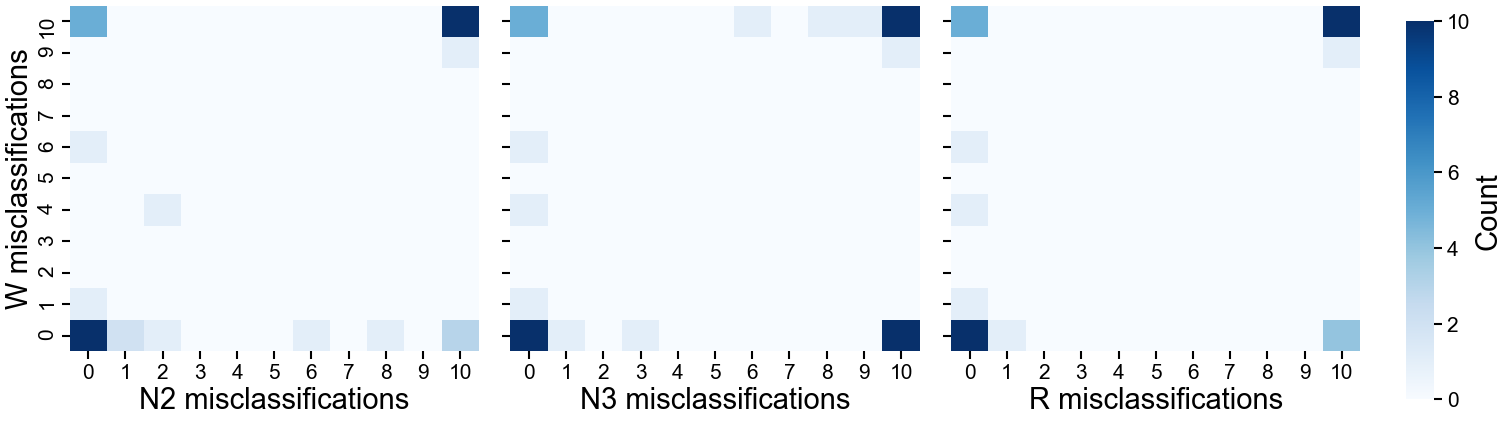

In [87]:

# combare N3 and W in a scatter plot
fig_scatter, axes_scatter = plt.subplots(1, 3, figsize=(120*MM_TO_IN, 40*MM_TO_IN))
fig_kde, axes_kde = plt.subplots(1, 3, figsize=(120*MM_TO_IN, 40*MM_TO_IN))

for i_ax, sleep_s, ax_scatter, ax_kde in zip(np.arange(3), ['N2', 'N3', 'R'], axes_scatter.flat, axes_kde.flat):
    chs = np.intersect1d(pct_misclass[pct_misclass.stage == sleep_s].idx, pct_misclass[pct_misclass.stage == 'W'].idx)
    im_scatter = ax_scatter.scatter(
        pct_misclass[(pct_misclass.stage == sleep_s) & (pct_misclass.idx.isin(chs))].is_misclassified,
        pct_misclass[(pct_misclass.stage == 'W') & (pct_misclass.idx.isin(chs))].is_misclassified,
        c='k',
        alpha=0.2,
        s=3
    )
    # ax_scatter.set_xticks(np.arange(11)); ax_scatter.set_yticks(np.arange(11))

    ax_scatter.set_xlabel(f'{sleep_s} misclassifications (%)')
    if i_ax == 0:
        ax_scatter.set_ylabel('W misclassifications (%)')
    else:
        ax_scatter.set_yticklabels([])


    
    # make a 10x10 heatmap
    x = pct_misclass[(pct_misclass.stage == sleep_s) & (pct_misclass.idx.isin(chs))].n_misclassified
    y = pct_misclass[(pct_misclass.stage == 'W') & (pct_misclass.idx.isin(chs))].n_misclassified

    X, Y = np.meshgrid(np.linspace(0, 10, 11), np.linspace(0, 10, 11))

    heatmap = np.zeros_like(X)
    for i in range(len(x)):
        heatmap[int(x.iloc[i]), int(y.iloc[i])] += 1
    
    if i_ax == 2:
        cbar = True
    else:
        cbar = False
    im_kde = sns.heatmap(
        heatmap.T,
        ax=ax_kde,
        cmap='Blues',
        cbar=cbar,
        vmin=0,
        vmax=10,
        # make cbar outside of plot
        cbar_ax=None if i_ax != 2 else fig_kde.add_axes([1.01, 0.1, 0.02, 0.8]),
        cbar_kws={'label': 'Count'},
    )
    ax_kde.invert_yaxis()

    ax_kde.set_xlabel(f'{sleep_s} misclassifications')
    if i_ax == 0:
        ax_kde.set_ylabel('W misclassifications')
    else:
        ax_kde.set_yticklabels([])



N2 vs W: p = 1.00e+00
N3 vs W: p = 1.03e-01
R vs W: p = 1.00e+00


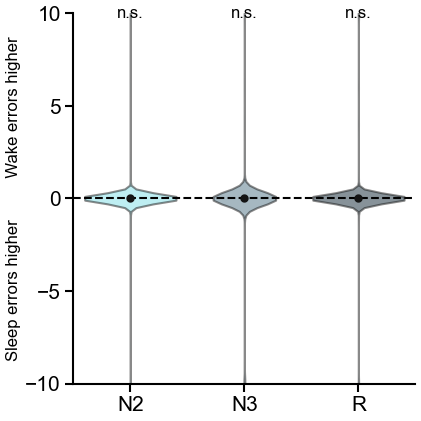

In [88]:
# make a boxplot of misclassifications
W_minus_sleep = []
for i_ax, sleep_s, ax in zip(np.arange(3), ['N2', 'N3', 'R'], axes_scatter.flat):
    chs = np.intersect1d(pct_misclass[pct_misclass.stage == sleep_s].idx, pct_misclass[pct_misclass.stage == 'W'].idx)
    W_minus_sleep.append(pct_misclass[(pct_misclass.stage == 'W') & (pct_misclass.idx.isin(chs))].n_misclassified.values - pct_misclass[(pct_misclass.stage == sleep_s) & (pct_misclass.idx.isin(chs))].n_misclassified.values)

fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))

sns.violinplot(
    data=W_minus_sleep,
    ax=ax,
    # showfliers=False,
    # notch=True
    palette={0: CONFIG.plotting.stage_colors['N2'], 1: CONFIG.plotting.stage_colors['N3'], 2: CONFIG.plotting.stage_colors['R']},
    cut=0
)
ax.set_ylim([-10, 10])
# make yticklabels reflect the subtraction
ax.set_xticklabels(['N2', 'N3', 'R'])
ax.set_ylabel('Sleep errors higher         Wake errors higher', fontsize=4)

for violin in ax.collections[::2]:
    violin.set_alpha(0.5)

# do stats to see if there are more errors in sleep than W
from scipy.stats import wilcoxon
for i, (sleep_s, diffs) in enumerate(zip(['N2', 'N3', 'R'], W_minus_sleep)):
    stat, pval = wilcoxon(diffs)
    pval = min(pval * 3, 1)
    print(f"{sleep_s} vs W: p = {pval:.2e}")

    # add annotation
    if pval < 5e-4:
        annot = '***'
    elif pval < 5e-3:
        annot = '**'
    elif pval < 5e-2:
        annot = '*'
    else:
        annot = 'n.s.'
    
    ax.text(i, 10, annot, ha='center', va='center', fontsize=4)

# center the y axis at 0
# ax.set_ylim([-15, 15])

ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
yticks = np.arange(-10, 11, 5)
ax.set_yticks(yticks)

# fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/misclassifications.pdf'), dpi=300, bbox_inches='tight')

## Patient-level abnormalities
### Load data

In [17]:
abnormality_probability = np.load(ospj(CONFIG.paths.data_dir, 'abnormality_probability.npy'))
all_resected_channels = pd.read_pickle(ospj(CONFIG.paths.data_dir, 'metadata/resected_channels.pkl'))
thresholds = pd.read_csv(ospj(CONFIG.paths.data_dir, 'adopted_thresholds.csv'))
thresholds = thresholds.query('key == 5')

master_channels = pd.read_csv(ospj(CONFIG.paths.data_dir, 'metadata/master_elecs.csv'))
master_channels['reg'] = master_channels.label.map(CONFIG.metadata_io.dkt_to_custom)

In [18]:
all_resected_channels.pt.nunique()

44

In [19]:
display(master_channels)

,rid,name,mni_x,mni_y,mni_z,mm_x,mm_y,mm_z,vox_x,vox_y,vox_z,label,soz,resected,spike_rate,engel_12,engel_24,reg
0,sub-RID0013,LST01,-51.0,-25.0,-32.0,-34.6751,-0.42270,-39.4603,80.6116,106.5480,64.5941,left inferior temporal,False,NaN,1.091902,1.2,1.1,Temporal_Inf_L
1,sub-RID0013,LST02,-61.0,-23.0,-35.0,-43.0088,2.37777,-40.9321,72.0779,109.4150,63.1223,left inferior temporal,False,NaN,1.091902,1.2,1.1,Temporal_Inf_L
2,sub-RID0013,LST03,-67.0,-19.0,-28.0,-50.0126,5.26941,-35.3090,64.9060,112.3760,68.7455,EmptyLabel,False,NaN,1.419472,1.2,1.1,NaN
3,sub-RID0013,LST04,-67.0,-15.0,-18.0,-49.9003,7.50003,-25.8205,65.0210,114.6600,78.2339,left middle temporal,False,NaN,0.655141,1.2,1.1,Temporal_Mid_L
4,sub-RID0013,MST01,7.0,-76.0,-11.0,15.2559,-41.60630,-33.6340,131.7410,64.3756,70.4205,right lingual,True,NaN,3.439490,1.2,1.1,Occipital_Med_R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14212,sub-RID0785,RB08,56.0,-40.0,22.0,54.7706,-22.78030,-19.5040,154.2550,114.2730,136.7560,EmptyLabel,False,False,0.369914,1.2,NaN,NaN
14213,sub-RID0785,RB09,59.0,-43.0,23.0,58.9395,-25.23490,-19.5579,159.1350,111.9920,136.6960,EmptyLabel,False,False,0.665845,1.2,NaN,NaN
14214,sub-RID0785,RB10,63.0,-47.0,23.0,63.7847,-27.57940,-18.5976,164.7520,109.9030,137.7640,right middle temporal,False,False,4.586930,1.2,NaN,Temporal_Mid_R
14215,sub-RID0785,RB11,65.0,-50.0,24.0,67.9536,-30.03410,-18.6515,169.6320,107.6220,137.7040,right middle temporal,False,False,2.071517,1.2,NaN,Temporal_Mid_R


In [20]:
params

{'spike_threshold': 1,
 'min_normative_bandpower': 10,
 'min_normative_coherence': 4,
 'engel_time': 24,
 'engel_threshold': 1.9}

In [30]:
RESECTED_ROI = False

resection_pts = sorted(metadata.pt.unique())
resection_pts = [pt for pt in resection_pts if pt in all_resected_channels.pt.unique()]
resection_pts = [pt for pt in resection_pts if pt not in pts_to_ignore]
print(f"Number of resection pts: {len(resection_pts)}")


Number of resection pts: 36
['sub-RID0018', 'sub-RID0020', 'sub-RID0032', 'sub-RID0033', 'sub-RID0050', 'sub-RID0063', 'sub-RID0064', 'sub-RID0101', 'sub-RID0117', 'sub-RID0139', 'sub-RID0143', 'sub-RID0160', 'sub-RID0167', 'sub-RID0175', 'sub-RID0179', 'sub-RID0238', 'sub-RID0274', 'sub-RID0278', 'sub-RID0294', 'sub-RID0295', 'sub-RID0301', 'sub-RID0309', 'sub-RID0325', 'sub-RID0365', 'sub-RID0371', 'sub-RID0381', 'sub-RID0405', 'sub-RID0424', 'sub-RID0440', 'sub-RID0442', 'sub-RID0490', 'sub-RID0508', 'sub-RID0522', 'sub-RID0648', 'sub-RID0658', 'sub-RID0785']


In [28]:

# params = params_li[4]['5']
params = params_li[-1]
key = list(params.keys())[0]
params = params[key]

all_metrics = []
for pt in resection_pts:
    group = metadata.query(f"pt == '{pt}'")
    engel_24 = group[f"engel_{params['engel_time']}"].iloc[0]
    engel_12 = group[f"engel_12"].iloc[0]
    pt_resected = all_resected_channels.query(f"pt == '{pt}'")

    if RESECTED_ROI:
        resected_rois = master_channels.query(f"rid == '{pt}' and name in @pt_resected.resected.values").reg.unique()
        resected_rois = sorted(resected_rois[~pd.isnull(resected_rois)])

        resected_idx = group.index[group.reg.isin(resected_rois)]
        nonresected_idx = group.index[~group.reg.isin(resected_rois)]

    else:
            
        ch1 = np.array([ch[0] for ch in group.name.str.split('-').values])
        ch2 = np.array([ch[1] for ch in group.name.str.split('-').values])

        resected_idx = group.index[(np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))]
        nonresected_idx = group.index[(~np.isin(ch1, pt_resected.resected.values) & ~np.isin(ch2, pt_resected.resected.values))]

    if len(resected_idx) == 0 or len(nonresected_idx) == 0:
        # print(f"{pt} has less than 1 matching resected channels")
        # print(f"{group.loc[resected_idx].name.values}")
        # print(f"{pt_resected.resected.values}")
        # print(f"{group.name.values}")
        continue


    resected_abnormality = abnormality_probability[:, resected_idx]
    nonresected_abnormality = abnormality_probability[:, nonresected_idx]

    # drop nans in resected and nonresected
    nans = np.isnan(resected_abnormality).all(axis=0)
    resected_abnormality = resected_abnormality[:, ~nans]
    resected_idx = resected_idx[~nans]

    nans = np.isnan(nonresected_abnormality).all(axis=0)
    nonresected_abnormality = nonresected_abnormality[:, ~nans]
    nonresected_idx = nonresected_idx[~nans]

    if len(resected_abnormality) == 0 or len(nonresected_abnormality) == 0:
        continue

    for i_stage, stage in enumerate(stages):
        y = np.concatenate([np.ones(len(resected_idx)), np.zeros(len(nonresected_idx))])
        y_pred = np.concatenate([resected_abnormality[i_stage], nonresected_abnormality[i_stage]])

        old_y = y.copy()
        # drop nans
        # nans = np.isnan(y_pred)
        # y = y[~nans]
        # y_pred = y_pred[~nans]

        # if np.sum(y == 0) <= 1:
        #     print(f"{pt} {stage} has less than 2 normal clips, originally {np.sum(old_y == 0)} normal")
        # if np.sum(y == 1) <= 1:
        #     print(f"{pt} {stage} has less than 2 abnormal clips, originally {np.sum(old_y == 1)} abnormal")

        # metrics to calculate are AUPRC and positive predictive value
        # check if pt is in the t
        thresh = thresholds[thresholds.stage == stage]
        thresh = thresh[thresh.apply(lambda x: pt in x.test_patients, axis=1)].threshold.values[0]

        ppv = precision_score(y, y_pred > thresh)

        nans = np.isnan(y_pred) | np.isnan(y)
        if np.all(nans):
            auprc = np.nan
        else:
            auprc = average_precision_score(y[~nans], y_pred[~nans])

        if (engel_12 <= params['engel_threshold']) & (engel_24 <= params['engel_threshold']):
            good_outcome = 'good'
        elif (np.isnan(engel_24)):
            good_outcome = np.nan
        else:
            good_outcome = 'poor'
        # elif engel >= 2:
        #     good_outcome = 'poor'
        # elif np.isnan(engel):
        #     good_outcome = np.nan
        # else:
        #     good_outcome = 'intermediate'
        #     # good_outcome = 'poor'

        all_metrics.append({
            'pt': pt,
            'stage': stage,
            'ppv': ppv,
            'auprc': auprc,
            'engel_12': engel_12,
            'engel_24': engel_24,
            'good_outcome': good_outcome
        })
all_metrics = pd.DataFrame(all_metrics)

# fill 0 ppv with nan
all_metrics.loc[all_metrics.ppv == 0, 'ppv'] = np.nan

all_metrics.dropna(subset=['engel_12', 'engel_24'], inplace=True)

display(all_metrics)

print(all_metrics.pt.nunique())
print(np.sum(np.isnan(all_metrics.ppv)))

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/p/pattnaik/.conda/

,pt,stage,ppv,auprc,engel_12,engel_24,good_outcome
0,sub-RID0018,N2,0.093023,0.128866,2.1,2.1,poor
1,sub-RID0018,N3,0.070175,0.091878,2.1,2.1,poor
2,sub-RID0018,R,0.117021,0.104945,2.1,2.1,poor
3,sub-RID0018,W,0.076923,0.100910,2.1,2.1,poor
4,sub-RID0020,N2,0.560000,0.679120,1.1,1.4,good
...,...,...,...,...,...,...,...
123,sub-RID0522,W,0.229167,0.293245,1.2,1.1,good
124,sub-RID0648,N2,0.021277,0.025641,4.1,4.1,poor
125,sub-RID0648,N3,NaN,0.043478,4.1,4.1,poor
126,sub-RID0648,R,NaN,NaN,4.1,4.1,poor


30
32


In [32]:
all_metrics.pt.nunique()
resection_pts = all_metrics.pt.unique()


print(resection_pts)
# save resesction pts
resection_pts = pd.DataFrame(resection_pts, columns=['pt'])
resection_pts.to_csv(ospj(CONFIG.paths.data_dir, 'metadata/resection_pts.csv'), index=False)

['sub-RID0018' 'sub-RID0020' 'sub-RID0032' 'sub-RID0033' 'sub-RID0050'
 'sub-RID0063' 'sub-RID0064' 'sub-RID0101' 'sub-RID0117' 'sub-RID0143'
 'sub-RID0160' 'sub-RID0167' 'sub-RID0175' 'sub-RID0179' 'sub-RID0274'
 'sub-RID0278' 'sub-RID0294' 'sub-RID0295' 'sub-RID0301' 'sub-RID0309'
 'sub-RID0325' 'sub-RID0371' 'sub-RID0381' 'sub-RID0405' 'sub-RID0424'
 'sub-RID0440' 'sub-RID0490' 'sub-RID0508' 'sub-RID0522' 'sub-RID0648']


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

N2_good vs. N2_poor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.233e-03 U_stat=1.690e+02
W_good vs. W_poor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.430e-02 U_stat=1.540e+02


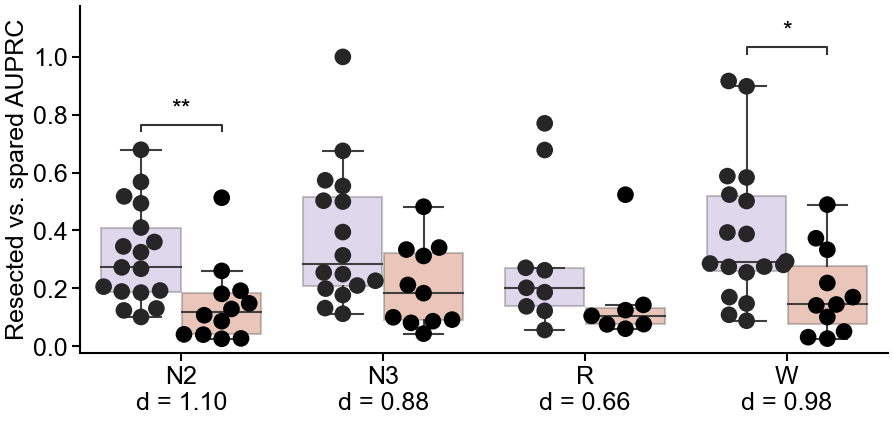

In [29]:
cohens_ds_uni = []

fig, ax = plt.subplots(1, 1, figsize=(80*MM_TO_IN, 40*MM_TO_IN))

plot_kwargs = {
    'data': all_metrics,
    'x': 'stage',
    'y': 'auprc',
    'hue': 'good_outcome',
    # 'flierprops': dict(marker='o', markersize=5, alpha=0),
    # 'palette': CONFIG.plotting.outcome_colors,
    'hue_order': ['good', 'poor'],
    'ax': ax
}

sns.boxplot(
    **plot_kwargs,
    boxprops=dict(alpha=0.3),
    showfliers=True,
    flierprops=dict(marker='o', markersize=5, alpha=0),
    palette=CONFIG.plotting.outcome_colors,
)
sns.swarmplot(
    **plot_kwargs,
    dodge=True,
    s=4,
    color='k'
)
if plot_kwargs['y'] == 'ppv':
    ax.set_ylabel("Positive predictive value", fontsize=8)
elif plot_kwargs['y'] == 'auprc':
    ax.set_ylabel("Resected vs. spared AUPRC", fontsize=6)
else:
    raise ValueError("y must be 'ppv' or 'auprc'")
ax.set_xlabel("")

# make yticklabels bigger
yticks = np.arange(0, 1.2, 0.2)
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y:.1f}" for y in yticks], fontsize=6)

handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
ax.legend(handles=handles, labels=["Engel 1", "Engel 2+"], fontsize=6, frameon=True, framealpha=0.2, loc='best')
ax.get_legend().remove()

pairs = [[(i, 'good'), (i, 'poor')] for i in stages]
annot = Annotator(
    plot='boxplot',
    pairs=pairs,
    verbose=True,
    **plot_kwargs,
    hide_non_significant=True
)
annot.configure(
    test='Mann-Whitney',
    loc='inside',
    comparisons_correction="Holm-Bonferroni",
    verbose=True,
    line_width=0.5,
)
annot.apply_test()
ax, test_results = annot.annotate()

for text in ax.texts:
    text.set_fontsize(6)

# plt.title('AUPRC by stage and outcome')
sns.despine()

def cohens_d(grp1, grp2):
    return (grp1.mean() - grp2.mean()) / np.sqrt((grp1.std() ** 2 + grp2.std() ** 2) / 2)

# add cohen's d to the xticks
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
new_xticklabels = []
for i, stage in enumerate(stages):
    # good_outcome = df[(df.stage == stage) & (df.outcome == 'good')].AUPRC
    # bad_outcome = df[(df.stage == stage) & (df.outcome == 'poor')].AUPRC
    good_outcome = plot_kwargs['data'][(plot_kwargs['data'].stage == stage) & (plot_kwargs['data'][plot_kwargs['hue']] == 'good')][plot_kwargs['y']]
    bad_outcome = plot_kwargs['data'][(plot_kwargs['data'].stage == stage) & (plot_kwargs['data'][plot_kwargs['hue']]  == 'poor')][plot_kwargs['y']]
    d = cohens_d(good_outcome, bad_outcome)
    cohens_ds_uni.append({
        'stage': stage,
        'd': d
    })
    x = xticks[i]
    # ax.text(x, 0.5, f"Cohen's d = {d:.2f}", ha='center', va='center', fontsize=8)
    # ax.set_xticklabels(f"{stage}\nCohen's d = {d:.2f}")
    new_xticklabels.append(f"{stage}\nd = {d:.2f}")
ax.set_xticklabels(new_xticklabels, fontsize=6)
ax.set_xlabel("")

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

fig.savefig(ospj(CONFIG.paths.fig_dir, f'affinity/{plot_kwargs["y"]}_by_stage.pdf'), dpi=300, bbox_inches='tight')

In [96]:
plotted = all_metrics[
    (all_metrics.good_outcome.isin(['good', 'poor'])) &
    (~all_metrics.ppv.isna())
    # (~all_metrics.engel.isna())
]
# for plotted make the stages columns and ppv their value, fill missing with nan
# plotted = plotted.pivot(index='pt', columns='stage', values='ppv')
plotted = plotted.pivot(index='pt', columns='stage', values='auprc')
plotted = plotted.reset_index()

plotted['engel_12'] = plotted['pt'].apply(lambda x: all_metrics.query(f"pt == '{x}'")['engel_12'].iloc[0])
plotted['engel_24'] = plotted['pt'].apply(lambda x: all_metrics.query(f"pt == '{x}'")['engel_24'].iloc[0])
plotted['good_outcome'] = plotted['pt'].apply(lambda x: all_metrics.query(f"pt == '{x}'")['good_outcome'].iloc[0])
plotted['W_minus_N2'] = plotted['W'] - plotted['N2']
plotted['W_minus_N3'] = plotted['W'] - plotted['N3']
plotted['W_minus_R'] = plotted['W'] - plotted['R']

# sort by mean W_minus_{stage}
case_study_candidates = plotted.iloc[np.argsort(np.nanmean([plotted['W_minus_N2'], plotted['W_minus_N3'], plotted['W_minus_R']], axis=0))].dropna()
case_study_candidates = plotted.iloc[np.argsort(np.nanmean([plotted['W'], plotted['N3'], plotted['R'], plotted['W']], axis=0))].dropna()
display(case_study_candidates)

case_study_1 = case_study_candidates[case_study_candidates.good_outcome == 'poor'].iloc[0].pt
case_study_2 = case_study_candidates[case_study_candidates.good_outcome == 'good'].iloc[-1].pt

case_study_2 = "sub-RID0522"

print(f"Two case study candidates: {case_study_1} and {case_study_2}")


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


stage,pt,N2,N3,R,W,engel_12,engel_24,good_outcome,W_minus_N2,W_minus_N3,W_minus_R
0,sub-RID0018,0.128866,0.091878,0.104945,0.100910,2.1,2.1,poor,-0.027956,0.009032,-0.004035
23,sub-RID0424,0.130592,0.131708,0.262534,0.088165,1.1,1.4,good,-0.042427,-0.043543,-0.174368
3,sub-RID0050,0.192523,0.177104,0.137821,0.147673,1.2,1.2,good,-0.044850,-0.029431,0.009851
25,sub-RID0490,0.191969,0.311985,0.075472,0.169742,2.2,2.2,poor,-0.022227,-0.142243,0.094269
17,sub-RID0301,0.205908,0.254945,0.271096,0.169865,1.1,1.1,good,-0.036043,-0.085080,-0.101231
7,sub-RID0117,0.185334,0.199127,0.122330,0.285813,1.1,1.1,good,0.100480,0.086687,0.163483
21,sub-RID0381,0.267859,0.209791,0.202000,0.281158,1.1,1.1,good,0.013298,0.071366,0.079157
27,sub-RID0522,0.360308,0.394547,0.186755,0.293245,1.2,1.1,good,-0.067063,-0.101302,0.106490
9,sub-RID0160,0.513276,0.482156,0.523685,0.489472,3.1,2.3,poor,-0.023804,0.007316,-0.034213
12,sub-RID0179,0.101010,0.112222,0.056061,0.916667,1.1,1.1,good,0.815657,0.804444,0.860606


Two case study candidates: sub-RID0018 and sub-RID0522


In [97]:
# print each stage for the two case study candidates
for pt in [case_study_1, case_study_2]:
    print(f"{pt}:")
    for stage in stages:
        ppv = all_metrics.query(f"pt == '{pt}' & stage == '{stage}'").ppv.values[0]
        auprc = all_metrics.query(f"pt == '{pt}' & stage == '{stage}'").auprc.values[0]
        print(f"{stage}: PPV = {ppv:.2f}, AUPRC = {auprc:.2f}")
    print()

for pt in [case_study_1, case_study_2]:
    group = metadata.query(f"pt == '{pt}'")
    engel = group[f"engel_{params['engel_time']}"].iloc[0]

    pt_resected = all_resected_channels.query(f"pt == '{pt}'")

    ch1 = np.array([ch[0] for ch in group.name.str.split('-').values])
    ch2 = np.array([ch[1] for ch in group.name.str.split('-').values])

    resected_idx = group.index[(np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))]
    nonresected_idx = group.index[(~np.isin(ch1, pt_resected.resected.values) & ~np.isin(ch2, pt_resected.resected.values))]

    print(f"{pt}: n_resected: {len(resected_idx)}, n_nonresected: {len(nonresected_idx)}")

sub-RID0018:
N2: PPV = 0.09, AUPRC = 0.13
N3: PPV = 0.07, AUPRC = 0.09
R: PPV = 0.12, AUPRC = 0.10
W: PPV = 0.08, AUPRC = 0.10

sub-RID0522:
N2: PPV = 0.26, AUPRC = 0.36
N3: PPV = 0.24, AUPRC = 0.39
R: PPV = 0.21, AUPRC = 0.19
W: PPV = 0.23, AUPRC = 0.29

sub-RID0018: n_resected: 13, n_nonresected: 88
sub-RID0522: n_resected: 12, n_nonresected: 42


In [98]:
all_example_pts = [case_study_1, case_study_2]

mesh_file = "/Volumes/DATA/Human_Data/CNT_iEEG_BIDS/{pt}/derivatives/freesurfer/surf/lh+rh_transform.pial"

for pt in all_example_pts:
    group = metadata.query(f"pt == '{pt}'")
    pt_abnormalities = abnormality_probability[:, group.index]

    # for visualization, change 0 to 0.01
    pt_abnormalities[pt_abnormalities == 0] = 0.01

    pt_resected = all_resected_channels.query(f"pt == '{pt}'")
    if len(pt_resected) == 0:
        continue

    ch1 = np.array([ch[0] for ch in group.name.str.split('-').values])
    ch2 = np.array([ch[1] for ch in group.name.str.split('-').values])

    resected_idx = group.index[(np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))]
    nonresected_idx = group.index[(~np.isin(ch1, pt_resected.resected.values) & ~np.isin(ch2, pt_resected.resected.values))]

    resected_abnormalities = abnormality_probability[:, resected_idx]
    nonresected_abnormalities = abnormality_probability[:, nonresected_idx]

    elecs_to_plot = (~np.isnan(pt_abnormalities).any(axis=0))


    resected_binary = (np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))
    resected_binary = (resected_binary.astype(int) * 99) + 1

    pt_coords = group[['mm_x', 'mm_y', 'mm_z']].values

    pt_mesh_file = mesh_file.format(pt=pt)

    stage = -1
    
    max_thresh = np.nanpercentile(pt_abnormalities[stage], 95) * 100
    non_nan = elecs_to_plot
    # for those not to plot set to 0
    pt_abnormalities[:, ~elecs_to_plot] = 0
    resected_binary[~elecs_to_plot] = 0

    for s in range(len(stages)):
        # non_nan = ~np.isnan(pt_abnormalities[s])
        test = plot_nodes(
            x = pt_coords[:, 0],
            y = pt_coords[:, 1],
            z = pt_coords[:, 2],
            c = pt_abnormalities[s] * 100,
            s = np.ones(len(pt_coords)) * 2,
            mesh_filename=pt_mesh_file,
            return_script=True,
            node_filename=f"{pt}_abnormality_stage_{stages[s]}",
            node_thresh=(0, max_thresh),
            out_filename=f"{pt}_abnormality_stage_{stages[s]}"
        )
        print(test)

    test = plot_nodes(
        x = pt_coords[:, 0],
        y = pt_coords[:, 1],
        z = pt_coords[:, 2],
        c = resected_binary,
        s = np.ones(len(pt_coords)) * 2,
        mesh_filename=pt_mesh_file,
        return_script=True,
        node_filename=f"{pt}_abnormality_stage_resected",
        node_thresh=(0, 100),
        out_filename=f"{pt}_abnormality_stage_resected"
    )
    print(test)


import gl
import os
gl.resetdefaults()
gl.meshload("/Volumes/DATA/Human_Data/CNT_iEEG_BIDS/sub-RID0018/derivatives/freesurfer/surf/lh+rh_transform.pial")

gl.nodeload("/Volumes/Users/pattnaik/ieeg_sleep_atlas/data/surfice_plotting/node_files/sub-RID0018_abnormality_stage_N2.node")
gl.nodesize(1.8, 1)
gl.shaderxray(0.6, .3)
gl.bmpzoom(1)
gl.nodethresh(0, 54.80000000000002)

if os.path.exists('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0018_abnormality_stage_N2_axial.png'): os.remove('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0018_abnormality_stage_N2_axial.png')
gl.viewaxial(1)
gl.wait(200)
gl.savebmp('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0018_abnormality_stage_N2_axial.png')
gl.wait(200)
gl.viewaxial(0)
if os.path.exists('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0018_abnormality_stage_N2_coronal.png'): os.remove('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0018_abnormality_s

In [102]:
%matplotlib inline
from IPython.display import Image

# load the image
for pt, view in zip(all_example_pts, ['sagittal', 'axial']):
    for stage in stages:
        print(f"{pt} {stage}")
        # img = Image(ospj(CONFIG.paths.fig_dir, "surfice", f"{pt}_abnormality_stage_{stage}_{view}.png"))
        # display(img)
    print(f"{pt} resected")
    # img = Image(ospj(CONFIG.paths.fig_dir, "surfice", f"{pt}_abnormality_stage_resected_{view}.png"))
    # display(img)

sub-RID0018 N2
sub-RID0018 N3
sub-RID0018 R
sub-RID0018 W
sub-RID0018 resected
sub-RID0522 N2
sub-RID0522 N3
sub-RID0522 R
sub-RID0522 W
sub-RID0522 resected


In [103]:
# repeat with combos
abnormality_probability_combo = np.load(ospj(CONFIG.paths.data_dir, 'abnormality_probability_combo.npy'))
combos = list(itertools.combinations(range(len(stages)), 2))
combos += [(i, i) for i in range(len(stages))]

thresholds = pd.read_pickle(ospj(CONFIG.paths.data_dir, 'adopted_thresholds_combo.pkl'))


In [104]:
print(params['engel_time'], params['engel_threshold'])

24 1.9


In [107]:
all_metrics_combos = []
for pt in resection_pts:
    group = metadata.query(f"pt == '{pt}'")
    # engel = group[f"engel_{params['engel_time']}"].iloc[0]
    engel_12 = group[f"engel_12"].iloc[0]
    engel_24 = group[f"engel_24"].iloc[0]

    pt_resected = all_resected_channels.query(f"pt == '{pt}'")

    ch1 = np.array([ch[0] for ch in group.name.str.split('-').values])
    ch2 = np.array([ch[1] for ch in group.name.str.split('-').values])

    resected_idx = group.index[(np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))]
    nonresected_idx = group.index[(~np.isin(ch1, pt_resected.resected.values) & ~np.isin(ch2, pt_resected.resected.values))]

    if len(resected_idx) == 0 or len(nonresected_idx) == 0:
        print(f"{pt} has less than 1 matching resected channels")
        print(f"{group.loc[resected_idx].name.values}")
        print(f"{pt_resected.resected.values}")
        print(f"{group.name.values}")
        continue


    resected_abnormality = abnormality_probability_combo[:, resected_idx]
    nonresected_abnormality = abnormality_probability_combo[:, nonresected_idx]

    # drop nans in resected and nonresected
    nans = np.isnan(resected_abnormality).all(axis=0)
    resected_abnormality = resected_abnormality[:, ~nans]
    resected_idx = resected_idx[~nans]

    nans = np.isnan(nonresected_abnormality).all(axis=0)
    nonresected_abnormality = nonresected_abnormality[:, ~nans]
    nonresected_idx = nonresected_idx[~nans]

    if len(resected_abnormality) == 0 or len(nonresected_abnormality) == 0:
        continue

    for i_combo, combo in enumerate(combos):
        if combo[0] == combo[1]:
            continue
        y = np.concatenate([np.ones(len(resected_idx)), np.zeros(len(nonresected_idx))])
        y_pred = np.concatenate([resected_abnormality[i_combo], nonresected_abnormality[i_combo]])

        old_y = y.copy()
        # drop nans
        # nans = np.isnan(y_pred)
        # y = y[~nans]
        # y_pred = y_pred[~nans]

        # if np.sum(y == 0) <= 1:
        #     print(f"{pt} {stage} has less than 2 normal clips, originally {np.sum(old_y == 0)} normal")
        # if np.sum(y == 1) <= 1:
        #     print(f"{pt} {stage} has less than 2 abnormal clips, originally {np.sum(old_y == 1)} abnormal")

        # metrics to calculate are AUPRC and positive predictive value
        # check if pt is in the t
        thresh = thresholds[thresholds.combo == (stages[combo[0]], stages[combo[1]])]
        thresh = thresh[thresh.apply(lambda x: pt in x.test_patients, axis=1)].threshold.values[0]

        ppv = precision_score(y, y_pred > thresh)

        nans = np.isnan(y_pred) | np.isnan(y)
        if np.all(nans):
            auprc = np.nan
        else:
            auprc = average_precision_score(y[~nans], y_pred[~nans])

        good_outcome = ['good' if engel <= params['engel_threshold'] else 'poor'][0]
        # if engel <= params['engel_threshold']:
        #     good_outcome = 'good'
        # elif engel >= 2:
        #     good_outcome = 'poor'
        # elif np.isnan(engel):
        #     good_outcome = np.nan
        # else:
        #     good_outcome = 'intermediate'
        #     # good_outcome = 'poor'
        if (engel_12 <= params['engel_threshold']) & (engel_24 <= params['engel_threshold']):
            good_outcome = 'good'
        elif (np.isnan(engel_24)):
            good_outcome = np.nan
        else:
            good_outcome = 'poor'

        all_metrics_combos.append({
            'pt': pt,
            'combo': combo,
            'ppv': ppv,
            'auprc': auprc,
            'engel_24': engel_24,
            'good_outcome': good_outcome
        })
all_metrics_combos = pd.DataFrame(all_metrics_combos)

# fill 0 ppv with nan
all_metrics_combos.loc[all_metrics_combos.ppv == 0, 'ppv'] = np.nan

# all_metrics_combos.dropna(subset=['engel_24'], inplace=True)

display(all_metrics_combos)


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/p/pattnaik/.conda/

sub-RID0238 has less than 1 matching resected channels
[]
['LG01' 'LG02' 'LG03']
['LA01-LA02' 'LA02-LA03' 'LA06-LA07' 'LA07-LA08' 'LB01-LB02' 'LB02-LB03'
 'LB03-LB04' 'LB07-LB08' 'LC01-LC02' 'LC02-LC03' 'LD01-LD02' 'LD02-LD03'
 'LD03-LD04' 'LD04-LD05' 'LD05-LD06' 'LD06-LD07' 'LE01-LE02' 'LE03-LE04'
 'LE04-LE05' 'LF01-LF02' 'LF02-LF03' 'LH01-LH02' 'LH03-LH04' 'RA01-RA02'
 'RA02-RA03' 'RA06-RA07' 'RA07-RA08' 'RB03-RB04' 'RB04-RB05' 'RB05-RB06'
 'RB06-RB07' 'RB07-RB08' 'RC01-RC02' 'RC02-RC03' 'RC03-RC04' 'RC04-RC05'
 'RC05-RC06' 'RC06-RC07' 'RC07-RC08' 'RD01-RD02' 'RD02-RD03' 'RD03-RD04'
 'RD04-RD05' 'RD05-RD06' 'RD06-RD07' 'RE05-RE06' 'RE06-RE07' 'RE07-RE08'
 'RF01-RF02' 'RF02-RF03' 'RF03-RF04' 'RG01-RG02' 'RG03-RG04' 'RG04-RG05'
 'RG05-RG06' 'RH05-RH06' 'RH06-RH07' 'RH07-RH08']
sub-RID0442 has less than 1 matching resected channels
[]
['RD01' 'RD02' 'RD03' 'RD04' 'RD05' 'RD06']
['LA01-LA02' 'LA02-LA03' 'LA07-LA08' 'LA08-LA09' 'LA09-LA10' 'LA10-LA11'
 'LA11-LA12' 'LB01-LB02' 'LB02-LB03' 

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/pytho

,pt,combo,ppv,auprc,engel_24,good_outcome
0,sub-RID0018,"(0, 1)",0.127660,0.106617,2.1,poor
1,sub-RID0018,"(0, 2)",0.097826,0.080483,2.1,poor
2,sub-RID0018,"(0, 3)",0.142857,0.137846,2.1,poor
3,sub-RID0018,"(1, 2)",0.115789,0.085145,2.1,poor
4,sub-RID0018,"(1, 3)",0.115385,0.090058,2.1,poor
...,...,...,...,...,...,...
193,sub-RID0785,"(0, 2)",NaN,NaN,NaN,NaN
194,sub-RID0785,"(0, 3)",0.166667,0.443452,NaN,NaN
195,sub-RID0785,"(1, 2)",NaN,NaN,NaN,NaN
196,sub-RID0785,"(1, 3)",0.058824,0.058440,NaN,NaN


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

(0, 2)_good vs. (0, 2)_poor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.867e-03 U_stat=5.600e+01
(0, 3)_good vs. (0, 3)_poor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.112e-03 U_stat=1.550e+02
(1, 3)_good vs. (1, 3)_poor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.228e-02 U_stat=1.280e+02


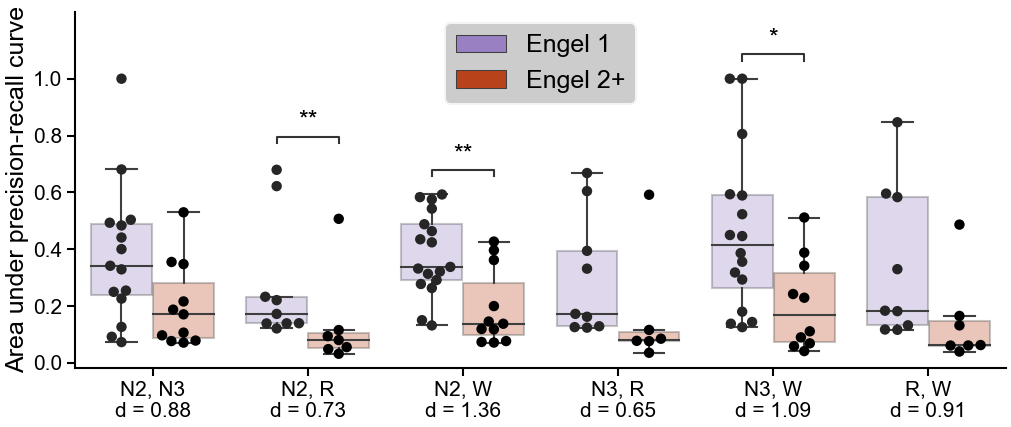

In [111]:
cohens_ds_bi = []

fig, ax = plt.subplots(1, 1, figsize=(90*MM_TO_IN, 40*MM_TO_IN))

plot_kwargs = {
    'data': all_metrics_combos,
    'x': 'combo',
    # 'y': 'ppv',
    'y': 'auprc',
    'hue': 'good_outcome',
    # 'flierprops': dict(marker='o', markersize=5, alpha=0),
    # 'palette': CONFIG.plotting.outcome_colors,
    'hue_order': ['good', 'poor'],
    'ax': ax
}

sns.boxplot(
    **plot_kwargs,
    boxprops=dict(alpha=0.3),
    showfliers=True,
    flierprops=dict(marker='o', markersize=5, alpha=0),
    palette=CONFIG.plotting.outcome_colors,
)
sns.swarmplot(
    **plot_kwargs,
    dodge=True,
    s=2.5,
    color='k'
)
if plot_kwargs['y'] == 'ppv':
    ax.set_ylabel("Positive predictive value", fontsize=6)
elif plot_kwargs['y'] == 'auprc':
    ax.set_ylabel("Area under precision-recall curve", fontsize=6)
ax.set_xlabel("")

handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
ax.legend(handles=handles, labels=["Engel 1", "Engel 2+"], fontsize=6, frameon=True, framealpha=0.2, loc='best')
# ax.get_legend().remove()

pairs = [[(i, 'good'), (i, 'poor')] for i in combos if i[0] != i[1]]
annot = Annotator(
    plot='boxplot',
    pairs=pairs,
    verbose=True,
    **plot_kwargs,
    hide_non_significant=True
)
annot.configure(
    test='Mann-Whitney',
    loc='inside',
    comparisons_correction="Holm-Bonferroni",
    verbose=True,
    line_width=0.5,
)
annot.apply_test()
ax, test_results = annot.annotate()

for text in ax.texts:
    text.set_fontsize(6)

# plt.title('AUPRC by stage and outcome')
sns.despine()

def cohens_d(grp1, grp2):
    return (grp1.mean() - grp2.mean()) / np.sqrt((grp1.std() ** 2 + grp2.std() ** 2) / 2)

# add cohen's d to the xticks
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
new_xticklabels = []
for i, combo in enumerate(combos):
    if combo[0] == combo[1]:
        continue
    # good_outcome = df[(df.stage == stage) & (df.outcome == 'good')].AUPRC
    # bad_outcome = df[(df.stage == stage) & (df.outcome == 'poor')].AUPRC
    good_outcome = plot_kwargs['data'][(plot_kwargs['data'].combo == combo) & (plot_kwargs['data'][plot_kwargs['hue']] == 'good')][plot_kwargs['y']]
    bad_outcome = plot_kwargs['data'][(plot_kwargs['data'].combo == combo) & (plot_kwargs['data'][plot_kwargs['hue']]  == 'poor')][plot_kwargs['y']]
    d = cohens_d(good_outcome, bad_outcome)
    cohens_ds_bi.append({
        "stage": (stages[combo[0]], stages[combo[1]]),
        'd': d
    })
    x = xticks[i]
    # ax.text(x, 0.5, f"Cohen's d = {d:.2f}", ha='center', va='center', fontsize=8)
    # ax.set_xticklabels(f"{stage}\nCohen's d = {d:.2f}")
    new_xticklabels.append(f"{stages[combo[0]]}, {stages[combo[1]]}\nd = {d:.2f}")
ax.set_xticklabels(new_xticklabels);
ax.set_xlabel("")

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# fig.savefig(ospj(CONFIG.paths.fig_dir, f'affinity/{plot_kwargs["y"]}_by_combo.pdf'), dpi=300, bbox_inches='tight')


In [112]:
cohens_ds = pd.DataFrame(cohens_ds_uni + cohens_ds_bi)
display(cohens_ds)

,stage,d
0,N2,1.099522
1,N3,0.878410
2,R,0.660616
3,W,0.982494
4,"(N2, N3)",0.877787
5,"(N2, R)",0.725502
6,"(N2, W)",1.360448
7,"(N3, R)",0.648069
8,"(N3, W)",1.088948
9,"(R, W)",0.905483


N2 vs N3: 1.10, 0.88, 0.88
N2 vs R: 1.10, 0.66, 0.73
N2 vs W: 1.10, 0.98, 1.36
N3 vs R: 0.88, 0.66, 0.65
N3 vs W: 0.88, 0.98, 1.09
R vs W: 0.66, 0.98, 0.91


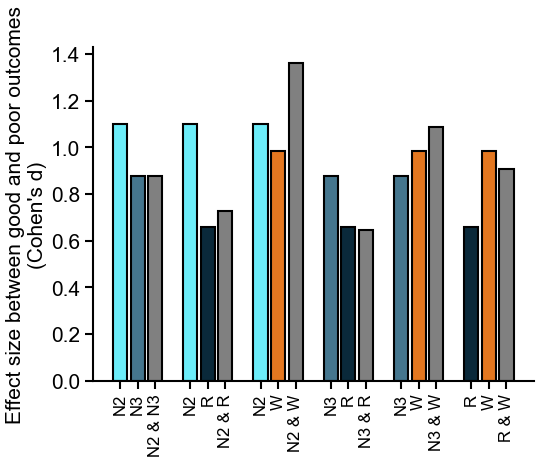

In [114]:
rcParams = plt.rcParams
rcParams['hatch.linewidth'] = 2
from copy import copy

sig_bars = [
    "N2",
    ("N2", "R"),
    ("N2", "W"),
    ("N3", "W"),
]

# make a barplot of cohen's ds
fig, ax = plt.subplots(1, 1, figsize=(50*MM_TO_IN, 40*MM_TO_IN))

combos_li = [(stages[combo[0]], stages[combo[1]]) for combo in combos]
combos_li = [combo for combo in combos_li if combo[0] != combo[1]]

for i, (combo_1, combo_2) in enumerate(combos_li):
    d_1 = cohens_ds.query(f"stage == '{combo_1}'").d.values[0]
    d_2 = cohens_ds.query(f"stage == '{combo_2}'").d.values[0]
    d_combined = cohens_ds[cohens_ds.stage == (combo_1, combo_2)].d.values[0]

    x_vals = 4*i + np.array([0, 1, 2])

    bar_kwargs = {
        "width": 0.8,
        "linewidth": 0.5,
        "edgecolor": 'black'
    }

    ax.bar(x_vals[0], d_1, color=CONFIG.plotting.stage_colors[combo_1], label=f"{combo_1}", **bar_kwargs)
    # if combo_1 in sig_bars:
    #     ax.text (x_vals[0], d_1 + 0.05, "*", ha='center', va='center', fontsize=8)
    ax.bar(x_vals[1], d_2, color=CONFIG.plotting.stage_colors[combo_2], label=f"{combo_2}", **bar_kwargs)
    # if combo_2 in sig_bars:
        # ax.text (x_vals[1], d_2 + 0.05, "*", ha='center', va='center', fontsize=8)
    bar = ax.bar(x_vals[2], d_combined, color='grey', label=f"{combo_1}, {combo_2}", **bar_kwargs)
    # if (combo_1, combo_2) in sig_bars:
        # ax.text (x_vals[2], d_combined + 0.05, "*", ha='center', va='center', fontsize=8)

    # rect = copy(bar.patches[0])
    # rect.set_facecolor('none')
    # rect.set_edgecolor('black')
    # rect.set_linewidth(0.5)
    # ax.add_patch(rect)


    # col_1 = CONFIG.plotting.stage_colors[combo_1]
    # col_2 = CONFIG.plotting.stage_colors[combo_2]
    # bar.patches[0].set_facecolor(col_1)
    # bar.patches[0].set_edgecolor(col_2)
    # bar.patches[0].set_hatch('////')
    # bar.patches[0].set_linewidth(0)

    print(f"{combo_1} vs {combo_2}: {d_1:.2f}, {d_2:.2f}, {d_combined:.2f}")

# xticks = np.arange(0, 4*len(combos_li), 4) + 1
xticks = np.hstack((range(0, 3), range(4, 7), range(8, 11), range(12, 15), range(16, 19), range(20, 23)))
# xticklabels = [f"{combo_1} & {combo_2}" for combo_1, combo_2 in combos_li]
xticklabels = np.hstack([[combo_1, combo_2, f"{combo_1} & {combo_2}"] for combo_1, combo_2 in combos_li])
ax.set_xticks(xticks); ax.set_xticklabels(xticklabels, rotation=90, ha='center', fontsize=4)

ax.set_ylabel("Effect size between good and poor outcomes\n(Cohen's d)", fontsize=5)

fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/cohen_d_by_combo.pdf'), dpi=600, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

(0, 3)_good vs. (0, 3)_poor: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.112e-03 U_stat=1.550e+02


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


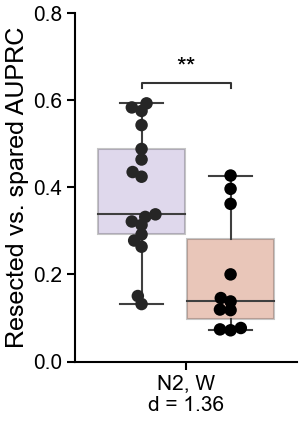

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


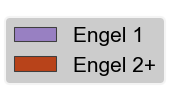

In [133]:
combo = (list(stages).index("N2"), list(stages).index("W"))

fig, ax = plt.subplots(1, 1, figsize=(30*MM_TO_IN, 40*MM_TO_IN))

# boxplot of N2 and Wake only
plot_kwargs = {
    'data': all_metrics_combos[all_metrics_combos.combo == combo],
    'x': 'combo',
    'y': 'auprc',
    'hue': 'good_outcome',
    'hue_order': ['good', 'poor'],
    'ax': ax
}

sns.boxplot(
    **plot_kwargs,
    boxprops=dict(alpha=0.3),
    showfliers=True,
    flierprops=dict(marker='o', markersize=5, alpha=0),
    palette=CONFIG.plotting.outcome_colors,
)
sns.swarmplot(
    **plot_kwargs,
    dodge=True,
    s=3,
    color='k',    
)
if plot_kwargs['y'] == 'ppv':
    ax.set_ylabel("Positive predictive value", fontsize=6)
elif plot_kwargs['y'] == 'auprc':
    ax.set_ylabel("Resected vs. spared AUPRC", fontsize=6)
ax.set_xlabel("")

handles, labels = ax.get_legend_handles_labels()
handles = handles[:2]
ax.legend(handles=handles, labels=["Engel 1", "Engel 2+"], fontsize=5, frameon=True, framealpha=0.2, loc='best')
# copy legend to new fig, ax
ax.get_legend().remove()

pairs = [[(i, 'good'), (i, 'poor')] for i in [combo]]
annot = Annotator(
    plot='boxplot',
    pairs=pairs,
    verbose=True,
    **plot_kwargs,
    hide_non_significant=False
)
annot.configure(
    test='Mann-Whitney',
    loc='inside',
    comparisons_correction="Holm-Bonferroni",
    verbose=True,
    line_width=0.5,
)
annot.apply_test()
ax, test_results = annot.annotate()

for text in ax.texts:
    text.set_fontsize(6)

# add cohen's d to the xticks
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
new_xticklabels = []
for i, combo in enumerate([combo]):
    if combo[0] == combo[1]:
        continue
    # good_outcome = df[(df.stage == stage) & (df.outcome == 'good')].AUPRC
    # bad_outcome = df[(df.stage == stage) & (df.outcome == 'poor')].AUPRC
    good_outcome = plot_kwargs['data'][(plot_kwargs['data'].combo == combo) & (plot_kwargs['data'][plot_kwargs['hue']] == 'good')][plot_kwargs['y']]
    bad_outcome = plot_kwargs['data'][(plot_kwargs['data'].combo == combo) & (plot_kwargs['data'][plot_kwargs['hue']]  == 'poor')][plot_kwargs['y']]
    d = cohens_d(good_outcome, bad_outcome)
    x = xticks[i]
    # ax.text(x, 0.5, f"Cohen's d = {d:.2f}", ha='center', va='center', fontsize=8)
    # ax.set_xticklabels(f"{stage}\nCohen's d = {d:.2f}")
    new_xticklabels.append(f"{stages[combo[0]]}, {stages[combo[1]]}\nd = {d:.2f}")
ax.set_xticklabels(new_xticklabels);
ax.set_xlabel("")

# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

fig.savefig(ospj(CONFIG.paths.fig_dir, f'affinity/{plot_kwargs["y"]}_for_N2_W.pdf'), dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(10*MM_TO_IN, 10*MM_TO_IN))
ax.legend(handles=handles, labels=["Engel 1", "Engel 2+"], fontsize=5, frameon=True, framealpha=0.2, loc='center')
ax.axis('off')
fig.savefig(ospj(CONFIG.paths.fig_dir, f'affinity/legend.pdf'), dpi=300, bbox_inches='tight')

In [134]:
df = all_metrics_combos[all_metrics_combos.combo == combo].dropna()
display(df)
example_subs = {}
example_subs['highest_good'] = df[df.good_outcome == 'good'].sort_values('auprc').iloc[-1].pt
example_subs['highest_poor'] = df[df.good_outcome == 'poor'].sort_values('auprc').iloc[-1].pt
example_subs['lowest_good'] = df[df.good_outcome == 'good'].sort_values('auprc').iloc[0].pt
example_subs['lowest_poor'] = df[df.good_outcome == 'poor'].sort_values('auprc').iloc[0].pt



,pt,combo,ppv,auprc,engel_24,good_outcome
2,sub-RID0018,"(0, 3)",0.142857,0.137846,2.1,poor
8,sub-RID0020,"(0, 3)",0.500000,0.592678,1.4,good
14,sub-RID0032,"(0, 3)",0.423077,0.463735,1.2,good
20,sub-RID0033,"(0, 3)",0.187500,0.337814,1.1,good
26,sub-RID0050,"(0, 3)",0.160714,0.150324,1.2,good
32,sub-RID0063,"(0, 3)",0.523810,0.542807,1.3,good
38,sub-RID0064,"(0, 3)",0.551724,0.575275,1.1,good
44,sub-RID0101,"(0, 3)",0.307692,0.424242,1.1,good
50,sub-RID0117,"(0, 3)",0.148148,0.263541,1.1,good
68,sub-RID0160,"(0, 3)",0.518519,0.426948,2.3,poor


In [135]:
abnormality_probability_combo.shape

(10, 9504)

In [136]:
combo

(0, 3)

In [137]:
combo_idx = combos.index(combo)

for cat, pt in example_subs.items():
    group = metadata.query(f"pt == '{pt}'")
    pt_abnormalities = abnormality_probability_combo[combo_idx, group.index]

    # for visualization, change 0 to 0.01
    pt_abnormalities[pt_abnormalities == 0] = 0.01

    pt_resected = all_resected_channels.query(f"pt == '{pt}'")
    if len(pt_resected) == 0:
        continue

    ch1 = np.array([ch[0] for ch in group.name.str.split('-').values])
    ch2 = np.array([ch[1] for ch in group.name.str.split('-').values])

    resected_idx = group.index[(np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))]
    nonresected_idx = group.index[(~np.isin(ch1, pt_resected.resected.values) & ~np.isin(ch2, pt_resected.resected.values))]

    resected_abnormalities = abnormality_probability_combo[combo_idx, resected_idx]
    nonresected_abnormalities = abnormality_probability_combo[combo_idx, nonresected_idx]

    elecs_to_plot = (~np.isnan(pt_abnormalities))

    resected_binary = (np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))
    resected_binary = (resected_binary.astype(int) * 99) + 1

    pt_coords = group[['mm_x', 'mm_y', 'mm_z']].values

    pt_mesh_file = mesh_file.format(pt=pt)

    max_thresh = np.nanpercentile(pt_abnormalities, 95) * 100
    # for those not to plot set to 0
    pt_abnormalities[~elecs_to_plot] = 0
    resected_binary[~elecs_to_plot] = 0

    # print(f"{pt} n_resected = {len(resected_idx)}, n_nonresected = {len(nonresected_idx)}")

    test = plot_nodes(
        x = pt_coords[:, 0],
        y = pt_coords[:, 1],
        z = pt_coords[:, 2],
        c = pt_abnormalities * 100,
        s = np.ones(len(pt_coords)) * 2,
        mesh_filename=pt_mesh_file,
        return_script=True,
        node_filename=f"{pt}_abnormality_stage_{stages[combo[0]]}_{stages[combo[1]]}",
        node_thresh=(0, max_thresh),
        out_filename=f"{pt}_abnormality_stage_{stages[combo[0]]}_{stages[combo[1]]}"
    )
    print(test)

    test = plot_nodes(
        x = pt_coords[:, 0],
        y = pt_coords[:, 1],
        z = pt_coords[:, 2],
        c = resected_binary,
        s = np.ones(len(pt_coords)) * 2,
        mesh_filename=pt_mesh_file,
        return_script=True,
        node_filename=f"{pt}_abnormality_stage_resected",
        node_thresh=(0, 100),
        out_filename=f"{pt}_abnormality_stage_resected"
    )
    print(test)


import gl
import os
gl.resetdefaults()
gl.meshload("/Volumes/DATA/Human_Data/CNT_iEEG_BIDS/sub-RID0020/derivatives/freesurfer/surf/lh+rh_transform.pial")

gl.nodeload("/Volumes/Users/pattnaik/ieeg_sleep_atlas/data/surfice_plotting/node_files/sub-RID0020_abnormality_stage_N2_W.node")
gl.nodesize(1.8, 1)
gl.shaderxray(0.6, .3)
gl.bmpzoom(1)
gl.nodethresh(0, 75.7)

if os.path.exists('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0020_abnormality_stage_N2_W_axial.png'): os.remove('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0020_abnormality_stage_N2_W_axial.png')
gl.viewaxial(1)
gl.wait(200)
gl.savebmp('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0020_abnormality_stage_N2_W_axial.png')
gl.wait(200)
gl.viewaxial(0)
if os.path.exists('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0020_abnormality_stage_N2_W_coronal.png'): os.remove('/Volumes/Users/pattnaik/ieeg_sleep_atlas/figures/surfice/sub-RID0020_abnormality_stag

In [138]:
for cat, pt in example_subs.items():
    group = metadata.query(f"pt == '{pt}'")
    pt_abnormalities = abnormality_probability_combo[combo_idx, group.index]

    # for visualization, change 0 to 0.01
    pt_abnormalities[pt_abnormalities == 0] = 0.01

    pt_resected = all_resected_channels.query(f"pt == '{pt}'")
    if len(pt_resected) == 0:
        continue

    ch1 = np.array([ch[0] for ch in group.name.str.split('-').values])
    ch2 = np.array([ch[1] for ch in group.name.str.split('-').values])

    resected_idx = group.index[(np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))]
    nonresected_idx = group.index[(~np.isin(ch1, pt_resected.resected.values) & ~np.isin(ch2, pt_resected.resected.values))]

    resected_abnormalities = abnormality_probability_combo[combo_idx, resected_idx]
    nonresected_abnormalities = abnormality_probability_combo[combo_idx, nonresected_idx]

    elecs_to_plot = (~np.isnan(pt_abnormalities))

    resected_binary = (np.isin(ch1, pt_resected.resected.values) | np.isin(ch2, pt_resected.resected.values))
    resected_binary = (resected_binary.astype(int) * 99) + 1

    pt_coords = group[['mm_x', 'mm_y', 'mm_z']].values

    pt_mesh_file = mesh_file.format(pt=pt)

    max_thresh = np.nanpercentile(pt_abnormalities, 95) * 100
    # for those not to plot set to 0
    pt_abnormalities[~elecs_to_plot] = 0
    resected_binary[~elecs_to_plot] = 0

    print(f"{cat}: {pt}")
    auprc = df.query(f'pt == "{pt}"').auprc.values[0]
    print(f"AUPRC = {auprc:.2f}")
    print(f"n_resected = {len(resected_idx)}, n_nonresected = {len(nonresected_idx)}")
    print()

highest_good: sub-RID0020
AUPRC = 0.59
n_resected = 45, n_nonresected = 29

highest_poor: sub-RID0160
AUPRC = 0.43
n_resected = 46, n_nonresected = 51

lowest_good: sub-RID0424
AUPRC = 0.13
n_resected = 11, n_nonresected = 73

lowest_poor: sub-RID0309
AUPRC = 0.07
n_resected = 4, n_nonresected = 75



N2, N3: AUC = 0.73
N2, R: AUC = 0.81
N2, W: AUC = 0.80
N3, R: AUC = 0.78
N3, W: AUC = 0.80
R, W: AUC = 0.74


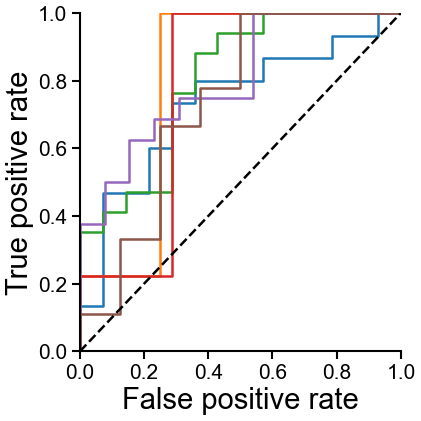

In [122]:
# calculate AUCs on AUPRC
from sklearn.metrics import roc_auc_score

fprs = []; tprs = []; aucs = []

for (i_combo, j_combo), group in all_metrics_combos.groupby('combo'):
    y_true = group.good_outcome == 'good'
    y_score = group.auprc

    nans = np.isnan(y_score)
    y_true = y_true[~nans]
    y_score = y_score[~nans]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    print(f"{stages[i_combo]}, {stages[j_combo]}: AUC = {auc:.2f}")
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)    
    # break

fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))

for fpr, tpr in zip(fprs, tprs):
    ax.plot(fpr, tpr, alpha=1, linewidth=0.6)

ax.plot([0, 1], [0, 1], linestyle='--', color='k', linewidth=0.6)

ax.set_xlabel('False positive rate'); ax.set_ylabel('True positive rate')
ax.set_xlim([0, 1]); ax.set_ylim([0, 1])

sns.despine()


## Neuropsychological testing analysis

In [123]:
stages = ['N2', 'N3', 'R', 'W']

cols = ['np_fsiq_pecclinical']
all_cols = ['np_fsiq_pecclinical', 'np_fsiq_percentile_pecclinical',
       'np_vci_score_pecclinical', 'np_vci_percentile_pecclinical',
       'np_pri_score_pecclinical', 'np_pri_percentile_pecclinical',
       'np_bdi_score_pecclinical', 'np_gad_score_pecclinical']

all_unique_cols = ['np_fsiq_pecclinical',
       'np_vci_score_pecclinical',
       'np_pri_score_pecclinical',
       'np_bdi_score_pecclinical', 'np_gad_score_pecclinical']
# cols = ['np_vci_score_pecclinical']
cols = ['np_fsiq_pecclinical',
       'np_vci_score_pecclinical',
       'np_pri_score_pecclinical',
       'np_bdi_score_pecclinical', 'np_gad_score_pecclinical']

cols = ["np_fsiq_pecclinical", "np_pri_score_pecclinical", "np_vci_score_pecclinical"]

good_names = {
    "np_fsiq_pecclinical": "Full-Scale Intelligence Quotient\n(score)",
    "np_fsiq_percentile_pecclinical": "Full-Scale Intelligence Quotient (\%ile)",
    "np_vci_score_pecclinical": "Verbal Comprehension Index\n(score)",
    "np_vci_percentile_pecclinical": "Verbal Comprehension Index\n(%ile)",
    "np_pri_score_pecclinical": "Perceptual Reasoning Index\n(score)",
    "np_pri_percentile_pecclinical": "Perceptual Reasoning Index (%ile)",
    "np_bdi_score_pecclinical": "Beck Depression Inventory\n(score)",
    "np_gad_score_pecclinical": "Generalized Anxiety Disorder 7\n(score)",
}

better = {
       "np_fsiq_pecclinical": "higher",
       "np_fsiq_percentile_pecclinical": "higher",
       "np_vci_score_pecclinical": "higher",
       "np_vci_percentile_pecclinical": "higher",
       "np_pri_score_pecclinical": "higher",
       "np_pri_percentile_pecclinical": "higher",
       "np_bdi_score_pecclinical": "lower",
       "np_gad_score_pecclinical": "lower",
       }

In [124]:
neuropsych_data_path = "/mnt/leif/littlab/users/pattnaik/ictal_patterns/data/metadata/Sleep Atlas Metadata.xlsx"
neuropsych_metadata = pd.read_excel(
    neuropsych_data_path,
    sheet_name="Neuropsych Testing v2",
    index_col=0
)
# make first row the column names and delete old column names
neuropsych_metadata.columns = neuropsych_metadata.iloc[0]
neuropsych_metadata = neuropsych_metadata.iloc[1:]
# convert int RID to sub-RIDXXXX
neuropsych_metadata.index = neuropsych_metadata.index.astype(str).str.zfill(4)
neuropsych_metadata.index = "sub-RID" + neuropsych_metadata.index
# add neuropsych testing to metadata
neuropsych_metadata = neuropsych_metadata[neuropsych_metadata.index.isin(metadata.pt.unique())]

abnormality_probability = np.load(ospj(CONFIG.paths.data_dir, 'abnormality_probability.npy'))
print(abnormality_probability.shape)

spike_counts = np.load(ospj(CONFIG.paths.data_dir, 'spike_counts.npy'))


(4, 9504)


In [125]:
beta_zscores = np.ones((len(stages), len(metadata))) * np.nan

file_path = "/mnt/leif/littlab/users/pattnaik/ieeg_sleep_atlas/data/features/multi_clip_features/bandpower_z_5.npy"

all_bp = np.load(file_path, allow_pickle=True)

for i_ch in range(all_bp.shape[0]):
    for i_stage in range(all_bp.shape[1]):
        if len(all_bp[i_ch, i_stage]) == 0:
            continue

        bps = np.array(all_bp[i_ch, i_stage])
        beta_bps = bps[:, 3]
        if np.all(np.isnan(beta_bps)):
            continue
        beta_zscores[i_stage, i_ch] = np.nanmedian(beta_bps)


Text(0.5, 27.33333333333336, 'Channels')

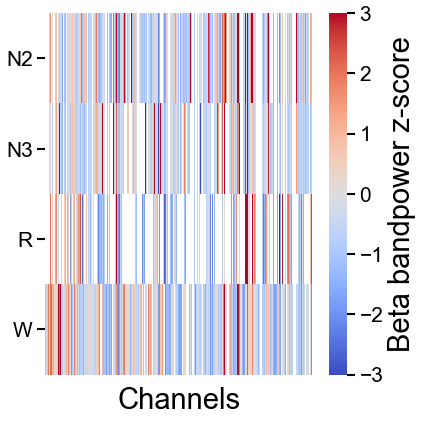

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))

sns.heatmap(
    beta_zscores,
    ax=ax,
    cbar_kws={'label': 'Beta bandpower z-score'},
    cmap='coolwarm',
    center=0,
    vmin=-3,
    vmax=3
)
ax.set_yticklabels(stages, rotation=0)
ax.set_xticks([])
ax.set_xlabel("Channels")

In [127]:
master_df = []
for pt in neuropsych_metadata.index:
    pt_metadata = metadata[metadata.pt == pt]
    pt_probs = abnormality_probability[:, pt_metadata.index]
    pt_spikes = spike_counts[:, pt_metadata.index]
    pt_beta = beta_zscores[:, pt_metadata.index]

    # take the average of hippocampal channels
    if np.all(np.isnan(pt_probs[:, pt_metadata.reg.isin(['Amyg_Hipp_R', 'Amyg_Hipp_L'])])):
        avg_hipp_epi = np.ones(4) * np.nan
    else:
        avg_hipp_epi = np.nanmedian(pt_probs[:, pt_metadata.reg.isin(['Amyg_Hipp_R', 'Amyg_Hipp_L'])], axis=1)

    avg_epi = np.nanmedian(pt_probs[:, (pt_metadata.ch1_resected | pt_metadata.ch2_resected)], axis=1)
    avg_epi = np.nanpercentile(pt_probs, 95, axis=1)
    avg_epi = np.nanmean(pt_probs, axis=1)

    if np.all(np.isnan(pt_spikes)):
        # avg_spikes = np.nan
        avg_spikes = np.ones(4) * np.nan
    else:
        avg_spikes = pt_spikes[:, pt_metadata.reg.isin(['Amyg_Hipp_R', 'Amyg_Hipp_L'])]
        if avg_spikes.shape[1] == 0:
            avg_spikes = np.ones(4) * np.nan
        else:
            avg_spikes = np.nanmedian(avg_spikes, axis=1)

    if np.all(np.isnan(pt_beta)):
        # avg_beta = np.nan
        avg_beta = np.ones(4) * np.nan
    else:
        # avg_beta = np.nanmean(pt_beta[:, condition], axis=1)
        # avg_beta = np.nanpercentile(pt_beta, 90, axis=1)
        avg_beta = pt_beta[:, pt_metadata.reg.isin(['Amyg_Hipp_R', 'Amyg_Hipp_L'])]
        if avg_beta.shape[1] == 0:
            avg_beta = np.ones(4) * np.nan
        else:
            avg_beta = np.nanmax(avg_beta, axis=1)
        # avg_beta = np.nanmax(pt_beta[:, pt_metadata.reg.isin(['Amyg_Hipp_R', 'Amyg_Hipp_L'])], axis=1)

    master_df.append({
        'pt': pt,
        # **{s: avg_epi[stages.index(s)] for s in stages},
        # **{s: avg_resection_epi[stages.index(s)] for s in stages},
        **{f"{s}_hipp": avg_hipp_epi[stages.index(s)] for s in stages},
        # **{f"{s}_resect": avg_resection_epi[stages.index(s)] for s in stages},
        **{f"{s}_all": avg_epi[stages.index(s)] for s in stages},
        **{f"{s}_spikes": avg_spikes[stages.index(s)] for s in stages},
        **{f"{s}_betaz": avg_beta[stages.index(s)] for s in stages},
        **{c: neuropsych_metadata.loc[pt, c] for c in all_cols},
        'engel_24': pt_metadata.engel_24.iloc[0],
    })

master_df = pd.DataFrame(master_df)
master_df = master_df.dropna(subset=['engel_24'])
print(master_df.shape)


/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: All-NaN slice encountered


(68, 26)


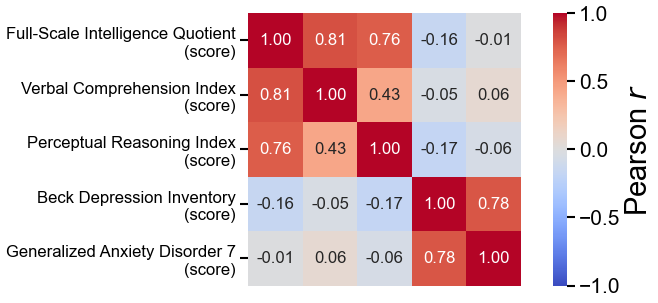

In [128]:
subset_cols = []
for col in all_cols:
    if "percentile" not in col:
        subset_cols.append(col)


fig, ax = plt.subplots(1, 1, figsize=(60*MM_TO_IN, 30*MM_TO_IN))
sns.heatmap(
    master_df[subset_cols].corr(),
    cmap='coolwarm', vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Pearson $r$'},
    ax=ax,
    annot=True,
    annot_kws={'fontsize': 4},
    fmt=".2f"
)
ax.set_yticklabels([good_names[i] for i in subset_cols], fontsize=4)
ax.set_xticks([])
ax.set_aspect('equal', 'box')

# save
fig.savefig(ospj(CONFIG.paths.fig_dir, 'affinity/neuropsych_corr.pdf'), dpi=300, bbox_inches='tight')

In [129]:
good_correlator_names = {
    "N2_all": "N2 Abn.",
    "N3_all": "N3 Abn.",
    "R_all": "R Abn.",
    "W_all": "W Abn.",
    "N2_resect": "N2 Abn.",
    "N3_resect": "N3 Abn.",
    "R_resect": "R Abn.",
    "W_resect": "W Abn.",
    "all_spike_rate": "All spike rate",
    "hipp_spike_rate": "Hipp. spike rate",
    "N2_hipp": "N2 Abn. (Hipp.)",
    "N3_hipp": "N3 Abn. (Hipp.)",
    "R_hipp": "R Abn. (Hipp.)",
    "W_hipp": "W Abn. (Hipp.)",
    "N2_spikes": "N2 spike rate",
    "N3_spikes": "N3 spike rate",
    "R_spikes": "R spike rate",
    "W_spikes": "W spike rate",
    "N2_betaz": "N2 beta power (z)",
    "N3_betaz": "N3 beta power (z)",
    "R_betaz": "R beta power (z)",
    "W_betaz": "W beta power (z)",
}

palette = {
    "N2_all": "tab:blue",
    "N3_all": "tab:blue",
    "R_all": "tab:blue",
    "W_all": "tab:blue",
    "N2_resect": "tab:blue",
    "N3_resect": "tab:blue",
    "R_resect": "tab:blue",
    "W_resect": "tab:blue",
    "all_spike_rate": "tab:red",
    "hipp_spike_rate": "tab:red",
    "N2_spikes": "tab:red",
    "N3_spikes": "tab:red",
    "R_spikes": "tab:red",
    "W_spikes": "tab:red",
    "N2_hipp": "tab:green",
    "N3_hipp": "tab:green",
    "R_hipp": "tab:green",
    "W_hipp": "tab:green",
    "N2_betaz": "tab:purple",
    "N3_betaz": "tab:purple",
    "R_betaz": "tab:purple",
    "W_betaz": "tab:purple",
}

In [130]:
# how many of each neuropsych test are not nan
for col in all_cols:
    print(f"{col}: {master_df[col].notnull().sum()}")

np_fsiq_pecclinical: 52
np_fsiq_percentile_pecclinical: 51
np_vci_score_pecclinical: 52
np_vci_percentile_pecclinical: 51
np_pri_score_pecclinical: 50
np_pri_percentile_pecclinical: 48
np_bdi_score_pecclinical: 42
np_gad_score_pecclinical: 37


(14, 26)
R^2: 0.57
r: 0.76
(20, 26)
R^2: 0.58
r: 0.76


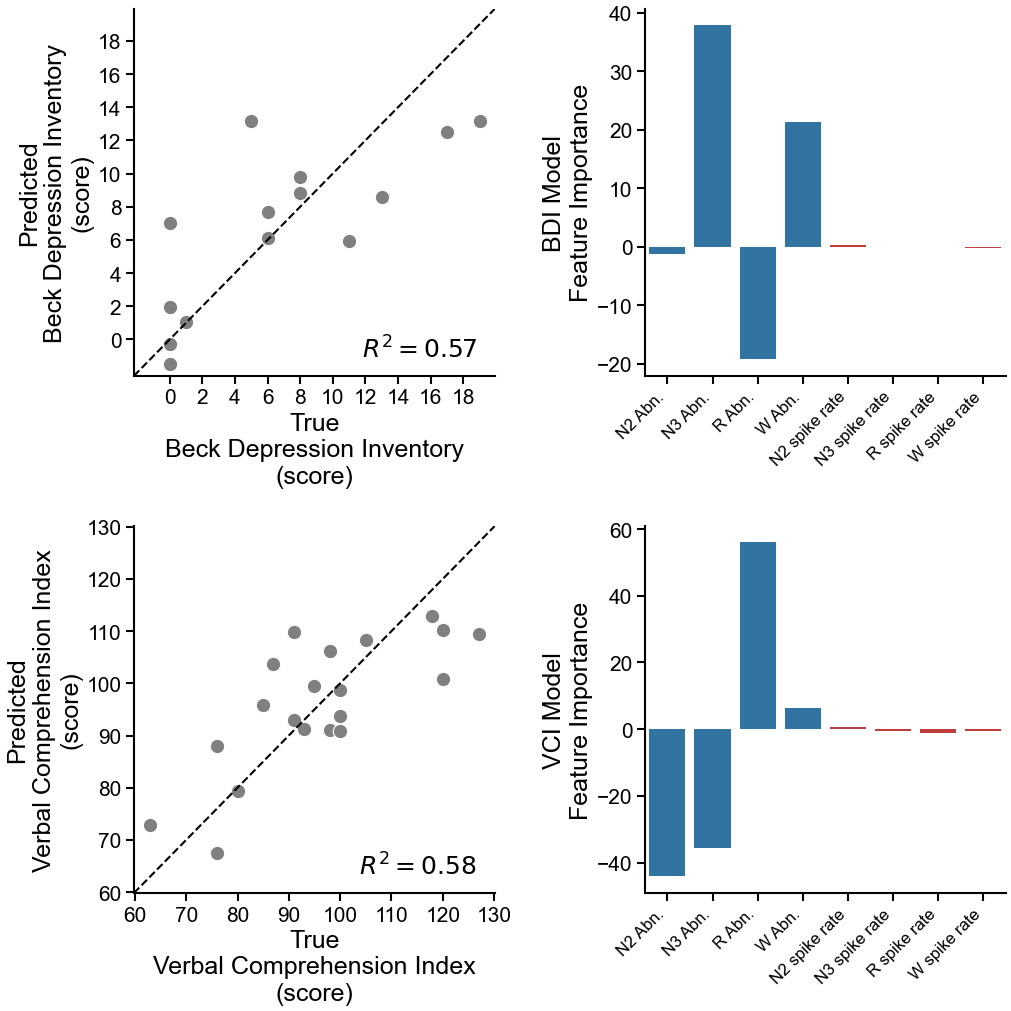

In [132]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression

X_cols = ["N2_hipp", "N3_hipp", "R_hipp", "W_hipp", "N2_spikes", "N3_spikes", "R_spikes", "W_spikes"]
X_cols = ["N2_hipp", "N3_hipp", "R_hipp", "W_hipp"]
X_cols = ["N2_all", "N3_all", "R_all", "W_all", "N2_spikes", "N3_spikes", "R_spikes", "W_spikes"]

fig, axes = plt.subplots(2, 2, figsize=(90*MM_TO_IN, 90*MM_TO_IN))

for i_ax, y_col in enumerate(["np_bdi_score_pecclinical", "np_vci_score_pecclinical"]):
    df = master_df.dropna(subset=X_cols + [y_col])

    print(df.shape)

    X = df[X_cols]
    y = df[y_col]

    model = LinearRegression(
        )
    model.fit(X, y)
    y_pred = model.predict(X)

    ax = axes[i_ax, 0]
    sns.scatterplot(
        x=y,
        y=y_pred,
        ax=ax,
        s=12,
        color="grey"
    )

    ax.set_xlabel(f"True\n{good_names[y_col]}", fontsize=6)
    ax.set_ylabel(f"Predicted\n{good_names[y_col]}", fontsize=6)

    if "bdi" in y_col:
    #     # set x and y ticks every 5 to 15
        ticks = np.arange(0, 20, 2)
    elif "vci" in y_col:
        ticks = np.arange(60, 140, 10)
    else:
        raise NotImplementedError
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    max_lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    min_lim = min(ax.get_xlim()[0], ax.get_ylim()[0])
    ax.set_xlim(min_lim, max_lim); ax.set_ylim(min_lim, max_lim)
    ax.plot([min_lim, max_lim], [min_lim, max_lim], 'k--')

    # get r^2
    r2 = model.score(X, y)
    print(f"R^2: {r2:.2f}")

    # add r2 in a textbox in the bottom right
    ax.text(0.95, 0.05, f"$R^2 = {r2:.2f}$", transform=ax.transAxes, ha='right', fontsize=6)

    r = np.corrcoef(y, y_pred)[0, 1]
    print(f"r: {r:.2f}")

    # do feature importance
    feature_importance = model.coef_

    # fig, ax = plt.subplots(1, 1, figsize=(40*MM_TO_IN, 40*MM_TO_IN))
    ax = axes[i_ax, 1]
    sns.barplot(
        x=X.columns,
        y=feature_importance,
        ax=ax,
        palette=palette
    )
    ax.set_xlabel("")
    # ax.set_ylabel("Feature Importance", fontsize=6)
    if i_ax == 0:
        ax.set_ylabel("BDI Model\nFeature Importance", fontsize=6)
    else:
        ax.set_ylabel("VCI Model\nFeature Importance", fontsize=6)
    ax.set_xticklabels([good_correlator_names[i] for i in X_cols], rotation=45, ha='right', fontsize=4)

fig.savefig(ospj(CONFIG.paths.fig_dir, f"affinity/neuropsych_linear_regression.pdf"), dpi=300, bbox_inches='tight')

In [374]:
# import statsmodel for linear regression
import statsmodels.api as sm

for y_col in ["np_bdi_score_pecclinical", "np_vci_percentile_pecclinical"]:
    df = master_df.dropna(subset=X_cols + [y_col])

    X = df[X_cols]
    y = df[y_col]

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    # LASSO model
    # model = sm.OLS(y, X).fit_regularized(alpha=0.1, L1_wt=1)
    print(model.summary())
    # print coefficients for each col
    # for i, col in enumerate(X_cols):
        # print(f"{col}: {model.params[i+1]:.2f}")

    # get r^2


                               OLS Regression Results                               
Dep. Variable:     np_bdi_score_pecclinical   R-squared:                       0.344
Model:                                  OLS   Adj. R-squared:                 -0.013
Method:                       Least Squares   F-statistic:                    0.9628
Date:                      Thu, 18 Jul 2024   Prob (F-statistic):              0.509
Time:                              16:06:58   Log-Likelihood:                -99.905
No. Observations:                        35   AIC:                             225.8
Df Residuals:                            22   BIC:                             246.0
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home1/p/pattnaik/.conda/envs/ieegpy-projects/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
